In [1]:
#initializing node structure
import chess
import chess.pgn
import chess.engine
import random
import time
import numpy as np
from math import log,sqrt,e,inf
from IPython.display import display, HTML, clear_output
engine = chess.engine.SimpleEngine.popen_uci(r'stockfish-11-win/Windows/stockfish_20011801_x64.exe')

#engine = chess.engine.SimpleEngine.popen_uci("stockfish")


class node:
    def __init__(self,*board):
        if(len(board)>0):
            self.state = board
        else:
            self.state = chess.Board()
        self.action = ''
        self.children = set()
        self.parent = None
        self.N = 0
        self.n = 0
        self.v = 0

In [2]:
#method for ucb and AI rollout
def ucb1(curr_node):
    ans = curr_node.v+2*(sqrt(log(curr_node.N+e+(10**-6))/(curr_node.n+(10**-10))))
    return ans

def rollout(board,curr_node):
    global engine
    if(curr_node.state.is_game_over()):
        board1 = curr_node.state
        if(board1.result()=='1-0'):
            return (1,curr_node)
        elif(board1.result()=='0-1'):
            return (-1,curr_node)
        else:
            return (0.5,curr_node)
    
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    result = engine.play(curr_node.state, chess.engine.Limit(time=0.001))
    move = curr_node.state.san(result.move)
    tmp_state = chess.Board(curr_node.state.fen())
    tmp_state.push_san(move)

    to_use = None
    
    for i in all_moves:
        tmp_state1 = chess.Board(curr_node.state.fen())
        tmp_state1.push_san(i)
        child = node()
        child.state = tmp_state1
        child.parent = curr_node
        curr_node.children.add(child)
        if(child.state==tmp_state):
            to_use = child
            break
            
    return rollout(board,to_use)





In [3]:
#method for baseline tree rollout
def rolloutTree(board,curr_node):
    
    if(curr_node.state.is_game_over()):
        board1 = curr_node.state
        if(board1.result()=='1-0'):
            return (1,curr_node)
        elif(board1.result()=='0-1'):
            return (-1,curr_node)
        else:
            return (0.5,curr_node)
    
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
    rnd_state = random.choice(list(curr_node.children))

    return rolloutTree(board,rnd_state)


In [4]:
def expand(curr_node,white):
    if(len(curr_node.children)==0):
        return curr_node
    max_ucb = -inf
    if(white):
        idx = -1
        max_ucb = -inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp>max_ucb):
                idx = i
                max_ucb = tmp
                sel_child = i

        return(expand(sel_child,0))

    else:
        idx = -1
        min_ucb = inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp<min_ucb):
                idx = i
                min_ucb = tmp
                sel_child = i

        return expand(sel_child,1)


In [5]:
def rollback(curr_node,reward):
    curr_node.n+=1
    curr_node.v+=reward
    while(curr_node.parent!=None):
        curr_node.N+=1
        curr_node = curr_node.parent
    return curr_node


In [6]:
def mcts_pred(board,curr_node,over,white,choice,base1,base2,iterations=10):
    if(over):
        return -1
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    map_state_move = dict()
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
        map_state_move[child] = i
        
    while(iterations>0):
        if(white):
            idx = -1
            max_ucb = -inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp>max_ucb):
                    idx = i
                    max_ucb = tmp
                    sel_child = i
            ex_child = expand(sel_child,0)
            if(base1=="Tree"):
                reward,state = rolloutTree(board,ex_child)
            elif(base1=="AI"):
                reward,state = rollout(board,ex_child)
            curr_node = rollback(state,reward)
            iterations-=1
        else:
            idx = -1
            min_ucb = inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp<min_ucb):
                    idx = i
                    min_ucb = tmp
                    sel_child = i

            ex_child = expand(sel_child,1)

            if(base2=="Tree"):
                reward,state = rolloutTree(board,ex_child)
            elif(base2=="AI"):
                reward,state = rollout(board,ex_child)

            curr_node = rollback(state,reward)
            iterations-=1

    if(white):
        
        mx = -inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp>mx):
                mx = tmp
                selected_move = map_state_move[i]
        return selected_move
    else:
        mn = inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp<mn):
                mn = tmp
                selected_move = map_state_move[i]
        return selected_move
    



In [7]:
def staticAnalysis(board, color):
    score = random.random()

    ## Check some things about this move:
    # score += 10 if board.is_capture(move) else 0
    # Now check some other things:
    for (piece, value) in [(chess.PAWN, 1), 
                           (chess.BISHOP, 4), 
                           (chess.KING, 0), 
                           (chess.QUEEN, 10), 
                           (chess.KNIGHT, 5),
                           (chess.ROOK, 3)]:
        score += len(board.pieces(piece, color)) * value
        score -= len(board.pieces(piece, not color)) * value
        # can also check things about the pieces position here
    # Check global things about the board
    score += 100 if board.is_checkmate() else 0
    return score



In [10]:
import os
import chess
import numpy as np
os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))
#os.chdir('C:\Users\User\Downloads\stockfish-11-win')
import chess.pgn
import pandas as pd
#https://www.kaggle.com/code/gabrielhaselhurst/chess-dataset/data
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}
csv = pd.read_csv('chessData.csv')

def make_matrix(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo
def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

import chess
import numpy as np
fen = csv['FEN'].values
values = csv['Evaluation'].values
length = 10000
X =[]
y= values[:length]
defects = []
for i in range(length):
    board = chess.Board(fen[i])
    matrix = make_matrix(board.copy())
    translated = translate(matrix,chess_dict)
    X.append(translated)
for i in range(length):
    if '#' in y[i]:
        y[i] = float(y[i][-1]) * 1000
y = y.astype('float32')

minimum = min(y)
maximum = max(y)
for i in range(len(y)):
    y[i] = (y[i]-minimum)/(maximum-minimum)
    


In [11]:
##Create and train the neural network
from keras import callbacks, optimizers
from keras.layers import (LSTM, BatchNormalization, Dense, Dropout, Flatten,
                          TimeDistributed)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, model_from_json
from IPython.display import clear_output
from matplotlib import pyplot as plt
model = Sequential()
model.add(Conv2D(filters=10, kernel_size=1, activation='relu', input_shape=(8,8,12)))
model.add(MaxPooling2D(pool_size=2, strides=None))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer = 'Adam',loss='mse')
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='val_loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=1)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
test = 1000
X = np.array(X)
X_train = X[test:]
y_train = y[test:]
X_test = X[:test]
y_test = y[:test]
model.fit(X_train,y_train,epochs = 1000,verbose = 2,validation_data = (X_test,y_test),callbacks = callback)

Training Network...
Epoch 1/1000
282/282 - 4s - loss: 0.0190 - val_loss: 0.0045 - 4s/epoch - 12ms/step
Epoch 2/1000
282/282 - 1s - loss: 0.0040 - val_loss: 0.0034 - 752ms/epoch - 3ms/step
Epoch 3/1000
282/282 - 1s - loss: 0.0030 - val_loss: 0.0024 - 731ms/epoch - 3ms/step
Epoch 4/1000
282/282 - 1s - loss: 0.0027 - val_loss: 0.0024 - 757ms/epoch - 3ms/step
Epoch 5/1000
282/282 - 1s - loss: 0.0026 - val_loss: 0.0024 - 674ms/epoch - 2ms/step
Epoch 6/1000
282/282 - 1s - loss: 0.0025 - val_loss: 0.0024 - 738ms/epoch - 3ms/step
Epoch 7/1000
282/282 - 1s - loss: 0.0024 - val_loss: 0.0023 - 765ms/epoch - 3ms/step
Epoch 8/1000
282/282 - 1s - loss: 0.0024 - val_loss: 0.0021 - 745ms/epoch - 3ms/step
Epoch 9/1000
282/282 - 1s - loss: 0.0024 - val_loss: 0.0022 - 679ms/epoch - 2ms/step
Epoch 10/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0022 - 676ms/epoch - 2ms/step
Epoch 11/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0022 - 668ms/epoch - 2ms/step
Epoch 12/1000
282/282 - 1s - loss: 0.0023 - v

Epoch 95/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 634ms/epoch - 2ms/step
Epoch 96/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 663ms/epoch - 2ms/step
Epoch 97/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 659ms/epoch - 2ms/step
Epoch 98/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 662ms/epoch - 2ms/step
Epoch 99/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 732ms/epoch - 3ms/step
Epoch 100/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 687ms/epoch - 2ms/step
Epoch 101/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 674ms/epoch - 2ms/step
Epoch 102/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 668ms/epoch - 2ms/step
Epoch 103/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 657ms/epoch - 2ms/step
Epoch 104/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 669ms/epoch - 2ms/step
Epoch 105/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 689ms/epoch - 2ms/step
Epoch 106/1000
282/282 - 1s - loss: 0.0021 - val

Epoch 190/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 661ms/epoch - 2ms/step
Epoch 191/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 639ms/epoch - 2ms/step
Epoch 192/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 683ms/epoch - 2ms/step
Epoch 193/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 657ms/epoch - 2ms/step
Epoch 194/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 660ms/epoch - 2ms/step
Epoch 195/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 661ms/epoch - 2ms/step
Epoch 196/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 662ms/epoch - 2ms/step
Epoch 197/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 661ms/epoch - 2ms/step
Epoch 198/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 670ms/epoch - 2ms/step
Epoch 199/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 656ms/epoch - 2ms/step
Epoch 200/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 667ms/epoch - 2ms/step
Epoch 201/1000
282/282 - 1s - loss: 0.0021 

282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 669ms/epoch - 2ms/step
Epoch 285/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 663ms/epoch - 2ms/step
Epoch 286/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 662ms/epoch - 2ms/step
Epoch 287/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 680ms/epoch - 2ms/step
Epoch 288/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 668ms/epoch - 2ms/step
Epoch 289/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 658ms/epoch - 2ms/step
Epoch 290/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 668ms/epoch - 2ms/step
Epoch 291/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 690ms/epoch - 2ms/step
Epoch 292/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 667ms/epoch - 2ms/step
Epoch 293/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 670ms/epoch - 2ms/step
Epoch 294/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 657ms/epoch - 2ms/step
Epoch 295/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0

Epoch 379/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 747ms/epoch - 3ms/step
Epoch 380/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 694ms/epoch - 2ms/step
Epoch 381/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 830ms/epoch - 3ms/step
Epoch 382/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 791ms/epoch - 3ms/step
Epoch 383/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 741ms/epoch - 3ms/step
Epoch 384/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 705ms/epoch - 2ms/step
Epoch 385/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 732ms/epoch - 3ms/step
Epoch 386/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 816ms/epoch - 3ms/step
Epoch 387/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 906ms/epoch - 3ms/step
Epoch 388/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 935ms/epoch - 3ms/step
Epoch 389/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 1s/epoch - 4ms/step
Epoch 390/1000
282/282 - 1s - loss: 0.0021 - v

Epoch 474/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 675ms/epoch - 2ms/step
Epoch 475/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 663ms/epoch - 2ms/step
Epoch 476/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 666ms/epoch - 2ms/step
Epoch 477/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 666ms/epoch - 2ms/step
Epoch 478/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 660ms/epoch - 2ms/step
Epoch 479/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 663ms/epoch - 2ms/step
Epoch 480/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 665ms/epoch - 2ms/step
Epoch 481/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 663ms/epoch - 2ms/step
Epoch 482/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 673ms/epoch - 2ms/step
Epoch 483/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 673ms/epoch - 2ms/step
Epoch 484/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 665ms/epoch - 2ms/step
Epoch 485/1000
282/282 - 1s - loss: 0.0021 

282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 650ms/epoch - 2ms/step
Epoch 569/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 667ms/epoch - 2ms/step
Epoch 570/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 661ms/epoch - 2ms/step
Epoch 571/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0025 - 668ms/epoch - 2ms/step
Epoch 572/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 668ms/epoch - 2ms/step
Epoch 573/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0024 - 662ms/epoch - 2ms/step
Epoch 574/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 677ms/epoch - 2ms/step
Epoch 575/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 705ms/epoch - 3ms/step
Epoch 576/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 661ms/epoch - 2ms/step
Epoch 577/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 686ms/epoch - 2ms/step
Epoch 578/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 667ms/epoch - 2ms/step
Epoch 579/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0

Epoch 663/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 706ms/epoch - 3ms/step
Epoch 664/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 686ms/epoch - 2ms/step
Epoch 665/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 682ms/epoch - 2ms/step
Epoch 666/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 725ms/epoch - 3ms/step
Epoch 667/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 677ms/epoch - 2ms/step
Epoch 668/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 660ms/epoch - 2ms/step
Epoch 669/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0025 - 667ms/epoch - 2ms/step
Epoch 670/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 663ms/epoch - 2ms/step
Epoch 671/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 671ms/epoch - 2ms/step
Epoch 672/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0026 - 677ms/epoch - 2ms/step
Epoch 673/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 685ms/epoch - 2ms/step
Epoch 674/1000
282/282 - 1s - loss: 0.0021 

282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 666ms/epoch - 2ms/step
Epoch 758/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 674ms/epoch - 2ms/step
Epoch 759/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 656ms/epoch - 2ms/step
Epoch 760/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 670ms/epoch - 2ms/step
Epoch 761/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 696ms/epoch - 2ms/step
Epoch 762/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 662ms/epoch - 2ms/step
Epoch 763/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 665ms/epoch - 2ms/step
Epoch 764/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 667ms/epoch - 2ms/step
Epoch 765/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 660ms/epoch - 2ms/step
Epoch 766/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 672ms/epoch - 2ms/step
Epoch 767/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 675ms/epoch - 2ms/step
Epoch 768/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0

Epoch 852/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0023 - 665ms/epoch - 2ms/step
Epoch 853/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 661ms/epoch - 2ms/step
Epoch 854/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 670ms/epoch - 2ms/step
Epoch 855/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 660ms/epoch - 2ms/step
Epoch 856/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 663ms/epoch - 2ms/step
Epoch 857/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 666ms/epoch - 2ms/step
Epoch 858/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 671ms/epoch - 2ms/step
Epoch 859/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 664ms/epoch - 2ms/step
Epoch 860/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 666ms/epoch - 2ms/step
Epoch 861/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 666ms/epoch - 2ms/step
Epoch 862/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0021 - 664ms/epoch - 2ms/step
Epoch 863/1000
282/282 - 1s - loss: 0.0021 

282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 672ms/epoch - 2ms/step
Epoch 947/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 672ms/epoch - 2ms/step
Epoch 948/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 669ms/epoch - 2ms/step
Epoch 949/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0020 - 678ms/epoch - 2ms/step
Epoch 950/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 667ms/epoch - 2ms/step
Epoch 951/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 671ms/epoch - 2ms/step
Epoch 952/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 686ms/epoch - 2ms/step
Epoch 953/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 674ms/epoch - 2ms/step
Epoch 954/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 662ms/epoch - 2ms/step
Epoch 955/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 670ms/epoch - 2ms/step
Epoch 956/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0022 - 666ms/epoch - 2ms/step
Epoch 957/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0

In [12]:
#load model
from keras.models import Sequential, load_model, model_from_json
def load_keras_model(dataset,loss,optimizer):
        json_file = open(dataset+'_best_model'+'.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        model.compile(optimizer=optimizer, loss=loss, metrics = None)
        model.load_weights(dataset+'_best_model'+'.h5')
        return model

In [13]:
import random
import chess
board = chess.Board()
moves = []
model = load_keras_model('chess','mse','Adam')
def calculate_move(depth,board,epochs):
    first_legal_moves = [board.san(i) for i in list(board.legal_moves)]
    #first_legal_moves = str(board.legal_moves)[38:-2].replace(',','').split()
    scores = [[0]] * len(first_legal_moves)
    for epoch in range(epochs):
        for first_move in range(len(first_legal_moves)):
            play_board = board.copy()
            play_board.push_san(first_legal_moves[first_move])
            for _ in range(depth):
                legal_moves = str(play_board.legal_moves)[38:-2].replace(',','').split()
                try:
                    move = random.choice(legal_moves)
                except:
                    scores[first_move] *= 1000
            matrix = make_matrix(play_board.copy())
            translated = np.array(translate(matrix,chess_dict))
            scores[first_move] += model.predict(translated.reshape(1,8,8,12))*(maximum-minimum)+minimum
        print('Epoch',str(epoch+1)+'/'+str(epochs))
    return first_legal_moves[scores.index(max(scores))]
#move= calculate_move1(10,chess.Board(),100)

In [15]:
#checking nn code
while True:
    print(board)
    legal_moves = str(board.legal_moves)[38:-2].replace(',','').split()
    print(board)
    matrix = make_matrix(board.copy())
    translated = np.array(translate(matrix,chess_dict))
    print(model.predict(translated.reshape(1,8,8,12)))
    clear_output()
    move = calculate_move(4,board,10)
    board.push_san(move)
    clear_output()
    print(str(board.legal_moves)[38:-2].replace(',','').split())
    move = input('Which move do you want to Play?')
    board.push_san(move)
    print(board)

['(Rxg8', 'Bg7', 'Be7', 'Bh6', 'Bd6', 'Bc5', 'Bb4', 'Ba3', 'Qe7', 'Qf6', 'Qg5', 'Qh4', 'Bb7', 'Ba6', 'Rb8', 'Nb8', 'Ne7', 'Ne5', 'Na5', 'Nd4', 'Nb4', 'h6', 'f6', 'd6', 'a6', 'g5', 'b5', 'h5', 'f5', 'd5', 'a5']


KeyboardInterrupt: Interrupted by user

In [17]:
#This method is for game that can be customized by the user

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
b1 = "8/8/7"+s+"/8/8/r7/1kr5/7K"
b2 = "8/8/8/8/B7/b6"+s+"/1kp5/7K"
b3 = "full board"
b4 = "8/1kr5/7"+s+"/8/8/r7/7K/8"
b5 = "8/7k/p1p2p2/7"+s+"/8/r7/1K1n4/8"
#b6= "8/8/8/8/8/8/7Q/5k1K"
print("select which problem instance board you want\n b1: ",b1,"\n b2:",b2,"\n b3: ",b3,"\n b4:",b4,"\n b5: ",b5)
b6 = input("Write b1 or b2 or b3 or b4 or b5")
if(b6=="b1"):
    board = chess.Board(b1)
elif(b6=="b2"):
    board = chess.Board(b2) 
elif(b6=="b3"):
    board = chess.Board()
elif(b6=="b4"):
    board = chess.Board(b4)
else:
    board = chess.Board(b5)
score=0

#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
#display_board(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
base1="AI"
base2="AI"
white = 1

if(choice==3):
    base1 = "Tree"

elif (choice==5):
    base2="NN"
    #white=0
elif(choice==4):
    base1="Tree"
    base2 = "Tree"
moves = 0
pgn = []
game = chess.pgn.Game()
evaluations = []
sm = 0
cnt = 0
curve  = [ [0]*2 for i in range(2)]
# curve = np.zeros((5,100,1000,2))

j=0
while((not board.is_game_over())):
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()
    if(white==1):
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    elif(choice==2 and white==0):
        print("input format should be something like a2, b6, g3, first one is row, second one is colum")
        print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
        to=input("Write where you want to go = ")
        frm = input("write from where you want to move = ")
        result=frm+to
    elif(choice==5 and white==0):
        start = time.time()
        #matrix = make_matrix(board.copy())
        translated = np.array(translate(matrix,chess_dict))
        #print(model.predict(translated.reshape(1,8,8,12)))
        #clear_output()
        #result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        result = calculate_move(3,board,5)
        #print("time taken for nn in iteration ",j,(time.time()-start))
    else:
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    try:
        board.push_san(result)

    except:
        print(result)
        print("invalid move. game over")
        break
    #print(result)
    score = staticAnalysis(board,white)
    col="BLACK"
    if(white):
        col="WHITE"
    print("score for ",col,"= ",score)

    curve[white].append(score)
    pgn.append(result)
    white ^= 1
    j+=1

    moves+=1
    #info = engine.analyse(board, chess.engine.Limit(depth=24))
    #evaluat += info['score'].white()
    print(board)

    print("-----------move done-----------")

print(" ".join(pgn))
print()
#{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

#print(info)
#print(evaluations)
#We are showing score for each player after each move, so in final result the score is only based on the winner.
#If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
print(board.result())

game.headers["Result"] = board.result()


We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?
p or P or Q or R or q or b . Only write the letter 
Q
select which problem instance board you want
 b1:  8/8/7Q/8/8/r7/1kr5/7K 
 b2: 8/8/8/8/B7/b6Q/1kp5/7K 
 b3:  full board 
 b4: 8/1kr5/7Q/8/8/r7/7K/8 
 b5:  8/7k/p1p2p2p/7Q/8/r7/1K1n4/8
Write b1 or b2 or b3 or b4 or b5b2
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
B . . . . . . .
b . . . . . . Q
. k p . . . . .
. . . . . . . K
Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?
 write 1 or 2 or 3 or 4 or 5= 5
time taken to iteration 0 3.70361065864563
score for  WHITE =  9.881860007909225
. . . . . . . .
. . . . . . . .
. . B . . . . .
. . . . . . . .
. . . . . . . .
b . . . . . . Q
. k p . . . . .
. . . . . . . K
-----------move done-----------
1/1 [=============================

1/1 [==============================] - 0s 27ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -6.345486252506118
. . . . . . . .
. . . . . . . .
. . B . . . . .
. . . . . . . .
. . . . . . . .
b . . . . . . Q
. k . . . . K .
. . . . . . . r
-----------move done-----------
time taken to iteration 4 3.4175000190734863
score for  WHITE =  7.480786276662707
. . . . . . . Q
. . . . . . . .
. . B . . . . .
. . . . . . . .
. . . . . . . .
b . . . . . . .
. k . . . . K .
. . . . . . . r
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 29ms/step
Epoch 2/5
1/1 [==============================] - 0s 42ms/step
Epoch 3/5
1/1 [==============================] - 0s 40ms/step
Epoch 4/5
1/1 [==============================] - 0s 33ms/step
Epoch 5/5
score for  BLACK =  -6.639929397369947
. . . . . . . Q
. . . . . . . .
. . B . . . . .
. . . . . . . .
. . . . . . . .
b . .

1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  3.5271565709332613
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . B . . . . .
. . . . . . . .
. . . . . . K .
b k . . . . . r
-----------move done-----------
time taken to iteration 12 3.048196792602539
score for  WHITE =  -2.097203758429716
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . B . . . .
. . . . . . . .
. . . . . . . .
. . . . . . K .
b k . . . . . r
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 29ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  3.8910879830479894
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . B . . . .
. . . . . . . .
. . . . . . . .
. . . . . . K r
b k . . . . . .
-----------move done-----------
time taken to iteration 14 2.2410597801208496
score for  WHITE =  0.9240738416834624
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . B . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . K
b k . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 27ms/step
Epoch 3/5
1/1 [==============================] - 0s 28ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  0.09356623668089803
. . . . . . . .
. . 

1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  0.2670793160164324
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . B . .
k . . . . . . K
b . . . . . . .
-----------move done-----------
time taken to iteration 18 2.3578426837921143
score for  WHITE =  0.10314222871084677
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
k . . . B . . K
b . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  0.5833824663545029
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. k . . B . . K
b . . . . . . .
-----------move 

1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.15104104300435583
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . B
. . . . . . . .
. . . . . . . K
. k . . . . . .
b . . . . . . .
-----------move done-----------
time taken to iteration 24 2.120288133621216
score for  WHITE =  0.3268232984597814
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . K
. k . . B . . .
b . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 29ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.3392667795897255
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. .

1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  0.5332981701743265
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . K
k . . . B . . .
b . . . . . . .
-----------move done-----------
time taken to iteration 30 1.8850915431976318
score for  WHITE =  0.9109019496543365
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . B . . . . .
. . . . . . . K
k . . . . . . .
b . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - 0s 27ms/step
Epoch 2/5
1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.013545540630317987
. . . . . . . .
. .

1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.3075010610092912
. . . . . . . .
. . . . . . . .
. . . . B . . .
. . . . . . . .
. . . . . K . .
. . . . . . . .
. . . . . . . .
b k . . . . . .
-----------move done-----------
time taken to iteration 38 1.2296998500823975
score for  WHITE =  0.721748055207982
. . . . . . . .
. . . . . . . .
. . . . B . . .
. . . . . . . .
. . . . . . . .
. . . . . . K .
. . . . . . . .
b k . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 27ms/step
Epoch 3/5
1/1 [==============================] - 0s 29ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  0.3255467479845606
. . . . . . . .
. . . 

1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  0.14135625760740567
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . B . . K . .
. . . . . . . .
. k . . . . . .
b . . . . . . .
-----------move done-----------
time taken to iteration 44 1.9882516860961914
score for  WHITE =  0.14323445364613097
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . B . . . K .
. . . . . . . .
. k . . . . . .
b . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  0.8875292701384465
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . B . . . K .
.

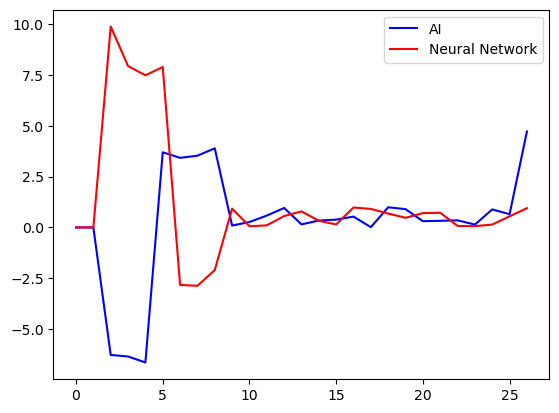

In [22]:
import numpy as np
import matplotlib.pyplot as pt


# visualize learning curves on train/test data
pt.plot(curve[0][0:j+1], 'b-')
pt.plot(curve[1][0:j+1], 'r-')
#pt.plot([0, len(curve[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
pt.legend(["AI","Neural Network"])
pt.show()

In [27]:
#This method is for game that can be customized by the user

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
b1 = "8/8/7"+s+"/8/8/r7/1kr5/7K"
b2 = "8/8/8/8/B7/b6"+s+"/1kp5/7K"
b3 = "full board"
b4 = "8/1kr5/7"+s+"/8/8/r7/7K/8"
b5 = "8/7k/p1p2p2/7"+s+"/8/r7/1K1n4/8"
#b6= "8/8/8/8/8/8/7Q/5k1K"
print("select which problem instance board you want\n b1: ",b1,"\n b2:",b2,"\n b3: ",b3,"\n b4:",b4,"\n b5: ",b5)
b6 = input("Write b1 or b2 or b3 or b4 or b5")
if(b6=="b1"):
    board = chess.Board(b1)
elif(b6=="b2"):
    board = chess.Board(b2) 
elif(b6=="b3"):
    board = chess.Board()
elif(b6=="b4"):
    board = chess.Board(b4)
else:
    board = chess.Board(b5)
score=0

#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
#display_board(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
base1="AI"
base2="AI"
white = 1

if(choice==3):
    base1 = "Tree"

elif (choice==5):
    base2="NN"
    #white=0
elif(choice==4):
    base1="Tree"
    base2 = "Tree"
moves = 0
pgn = []
game = chess.pgn.Game()
evaluations = []
sm = 0
cnt = 0
curve  = [ [0]*2 for i in range(2)]
# curve = np.zeros((5,100,1000,2))

j=0
while((not board.is_game_over())):
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()
    if(white==1):
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    elif(choice==2 and white==0):
        print("input format should be something like a2, b6, g3, first one is row, second one is colum")
        print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
        to=input("Write where you want to go = ")
        frm = input("write from where you want to move = ")
        result=frm+to
    elif(choice==5 and white==0):
        start = time.time()
        #matrix = make_matrix(board.copy())
        translated = np.array(translate(matrix,chess_dict))
        #print(model.predict(translated.reshape(1,8,8,12)))
        #clear_output()
        #result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        result = calculate_move(3,board,5)
        #print("time taken for nn in iteration ",j,(time.time()-start))
    else:
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    try:
        board.push_san(result)

    except:
        print(result)
        print("invalid move. game over")
        break
    #print(result)
    score = staticAnalysis(board,white)
    col="BLACK"
    if(white):
        col="WHITE"
    print("score for ",col,"= ",score)

    curve[white].append(score)
    pgn.append(result)
    white ^= 1
    j+=1

    moves+=1
    #info = engine.analyse(board, chess.engine.Limit(depth=24))
    #evaluat += info['score'].white()
    print(board)

    print("-----------move done-----------")

print(" ".join(pgn))
print()
#{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

#print(info)
#print(evaluations)
#We are showing score for each player after each move, so in final result the score is only based on the winner.
#If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
print(board.result())

game.headers["Result"] = board.result()


We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?
p or P or Q or R or q or b . Only write the letter 
p
select which problem instance board you want
 b1:  8/8/7p/8/8/r7/1kr5/7K 
 b2: 8/8/8/8/B7/b6p/1kp5/7K 
 b3:  full board 
 b4: 8/1kr5/7p/8/8/r7/7K/8 
 b5:  8/7k/p1p2p2p/7p/8/r7/1K1n4/8
Write b1 or b2 or b3 or b4 or b5b3
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?
 write 1 or 2 or 3 or 4 or 5= 5
time taken to iteration 0 19.0200457572937
score for  WHITE =  0.15796582637600487
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . P . . .
P P P P . P P P
R N B Q K B N R
-----------move done-----------
1/1 [===========================

1/1 [==============================] - 0s 27ms/step
Epoch 2/5
1/1 [==============================] - 0s 38ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 29ms/step
Epoch 5/5
score for  BLACK =  0.7405836209077528
r n b q k b . r
p p p . p p p p
. . . p . . . n
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
-----------move done-----------
time taken to iteration 4 14.09669542312622
score for  WHITE =  0.27313994604187464
r n b q k b . r
p p p . p p p p
. . . p . . . n
. . . . . . . .
. . . . P . . .
. . . . . P . .
P P P P . . P P
R N B Q K B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.45877477118571264
r n b q . b . r
p p p k p p p p
. . . p . . . n
. . . . . . . .
. . . . P . . .
. . . . . P . .
P P P P . . P P
R N B Q K B N R
-----------move done-----------
time taken to iteration 6 14.444052457809448
score for  WHITE =  0.582115379370336
r n b q . b . r
p p p k p p p p
. . . p . . . n
. . . . . . . .
. . . . P . . .
. . . . . P . .
P P P P . K P P
R N B Q . B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.035331539631554776
r n b q . b . r
p p p k p . p p
. . . p . p . n
. . . . . . . .
. . . . P . . .
. . . . . P . .
P P P P . K P P
R N B Q . B N R
-----------move done-----------
time taken to iteration 8 17.76132321357727
score for  WHITE =  0.5467611323906141
r n b q . b . r
p p p k p . p p
. . . p . p . n
. B . . . . . .
. . . . P . . .
. . . . . P . .
P P P P . K P P
R N B Q . . N R
-----------move done-----------
1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.08473574938841821
r n b q . b . r
p p . k p . p p
. . p p . p . n
. B . . . . . .
. . . . P . . .
. 

1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  0.39683911909571634
r n b q . b . r
p p . k . . p p
. . p p p p . n
. B . . . . . .
. . . P P . . .
. . . . . P . .
P P P . . K P P
R N B Q . . N R
-----------move done-----------
time taken to iteration 12 17.57570242881775
score for  WHITE =  0.19396051433631634
r n b q . b . r
p p . k . . p p
. . p p p p . n
. . . . . . . .
. . . P P . . .
. . . . . P . .
P P P . . K P P
R N B Q . B N R
-----------move done-----------
1/1 [==============================] - 0s 35ms/step
Epoch 1/5
1/1 [==============================] - 0s 41ms/step
Epoch 2/5
1/1 [==============================] - 0s 37ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  0.4654583010484643
r n b . q b . r
p p . k . . p p
. . p p p p . n
. . . . . . . .
. . . P P . . .
. . . . . P . .
P P P . . K P P
R N B Q . B N R
-----------move 

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  0.5654262639014291
r n b . q b r .
p p . k . . p p
. . p p p p . n
. . . . P . . .
. . . P . . . .
. . . . . P . .
P P P . . K P P
R N B Q . B N R
-----------move done-----------
time taken to iteration 16 13.658205509185791
score for  WHITE =  0.7019571611121247
r n b . q b r .
p p . k . . p p
. . p p p p . n
. . . . P . . .
. . P P . . . .
. . . . . P . .
P P . . . K P P
R N B Q . B N R
-----------move done-----------
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  0.15649542227394697
r n b . q b . r
p p . k . . p p
. . p p p p . n
. . . . P . . .
. . P P . . . .
. . . . . P . .
P P . . . K P P
R N B Q . B N R
-----------move done-----------
time taken to iteration 18 13.915631532669067
score for  WHITE =  0.7522297508835347
r n b . q b . r
p p . k . . p p
. . p p p p . n
. . . . P . . .
. . P P . . . .
. Q . . . P . .
P P . . . K P P
R N B . . B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.21437600815701785
r n b . q b r .
p p . k . . p p
. . p p p p . n
. . . . P . . .
. . P P . . . .
. Q . . . P . .
P P . . . K P P
R N B . . B N R
-----------move done-----------
time taken to iteration 20 15.124343395233154
score for  WHITE =  0.7100450539166907
r n b . q b r .
p p . k . . p p
. . p p p p . n
. . . . P . . .
P . P P . . . .
. Q . . . P . .
. P . . . K P P
R N B . . B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  0.9229216724695046
r n b . q b . r
p p . k . . p p
. . p p p p . n
. . . . P . . .
P . P P . . . .
. Q . . . P . .
. P . . . K P P
R N B . . B N R
-----------move done-----------
time taken to iteration 22 19.31274652481079
score for  WHITE =  0.708151203586386
r n b . q b . r
p p . k . . p p
. . p p p p . n
. Q . . P . . .
P . P P . . . .
. . . . . P . .
. P . . . K P P
R N B . . B N R
-----------move done-----------
1/1 [==============================] - 0s 30ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.16443147071825948
r n b . q b r .
p p . k . . p p
. . p p p p . n
. Q . . P . . .
P . P P . . . .
. . . . . P . .
. P . . . K P P
R N B . . B N R
-----------move done-----------
time taken to iteration 24 13.781795263290405
score for  WHITE =  0.10889541648760748
r n b . q b r .
p p . k . . p p
. . p p p p . n
. Q . P P . . .
P . P . . . . .
. . . . . P . .
. P . . . K P P
R N B . . B N R
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 27ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.5528644255008182
r n b . q b . r
p p . k . . p p
. . p p p p . n
. Q . P P . . .
P . P . . . . .
. . . . . P . .
. P . . . K P P
R N B . . B N R
-----------move done-----------
time taken to iteration 26 14.628517389297485
score for  WHITE =  0.19543162973741346
r n b . q b . r
p p . k . . p p
. Q p p p p . n
. . . P P . . .
P . P . . . . .
. . . . . P . .
. P . . . K P P
R N B . . B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  0.9449766379154223
r n b . q b r .
p p . k . . p p
. Q p p p p . n
. . . P P . . .
P . P . . . . .
. . . . . P . .
. P . . . K P P
R N B . . B N R
-----------move 

1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 29ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  0.579712531817064
r n b . q b . r
p p . k . . p p
. Q p p p p . n
. . . P P . . .
P . P . . . . .
. . . B . P . .
. P . . . K P P
R N B . . . N R
-----------move done-----------
time taken to iteration 30 16.27714991569519
score for  WHITE =  0.6528603058297868
r n b . q b . r
p p . k . . p p
. Q p p p p . n
. . . P P . . .
P . P . . . . .
N . . B . P . .
. P . . . K P P
R . B . . . N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  0.7805276787918807
r n b . q b r .
p p . k . . p p
. Q p p p p . n
. . . P P . . .
P . P . . . . .
N . . B . P . .
. P . . . K P P
R . B . . . N R
-----------move done-----------
time taken to iteration 32 17.003685235977173
score for  WHITE =  0.2950594018471566
r n b . q b r .
p p . k . . p p
. Q p p p p . n
. . . P P . . .
P . P . . . . .
N . . B . P . .
. P . . . . P P
R . B . K . N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.14197343797086504
r n b . q b . r
p p . k . . p p
. Q p p p p . n
. . . P P . . .
P . P . . . . .
N . . B . P . .
. P . . . . P P
R . B . K . N R
-----------move done-----------
time taken to iteration 34 15.620514631271362
score for  WHITE =  0.7937737266188076
r n b . q b . r
p p . k . . p p
. . p p p p . n
Q . . P P . . .
P . P . . . . .
N . . B . P . .
. P . . . . P P
R . B . K . N R
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 27ms/step
Epoch 5/5
score for  BLACK =  0.636527611021906
r n b . q b r .
p p . k . . p p
. . p p p p . n
Q . . P P . . .
P . P . . . . .
N . . B . P . .
. P . . . . P P
R . B . K . N R
-----------move done-----------
time taken to iteration 36 16.226326942443848
score for  WHITE =  0.15671764814496925
r n b . q b r .
p p . k . . p p
. . p p p p . n
. . . P P . . .
P . P . . . . .
N . . B . P . .
. P . Q . . P P
R . B . K . N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step
Epoch 5/5
score for  BLACK =  0.48139550009145715
r n b . q b . r
p p . k . . p p
. . p p p p . n
. . . P P . . .
P . P . . . . .
N . . B . P . .
. P . Q . . P P
R . B . K . N R
-----------move done-----------
time taken to iteration 38 17.05407428741455
score for  WHITE =  0.6294186030702136
r n b . q b . r
p p . k . . p p
. . p p p p . n
. . . P P . . .
P . P . . . . .
N . . B . P . .
. P . Q . . P P
R . B K . . N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  0.09923932682472802
r n b . q b r .
p p . k . . p p
. . p p p p . n
. . . P P . . .
P . P . . . . .
N . . B . P . .
. P . Q . . P P
R . B K . . N R
-----------move 

time taken to iteration 40 15.664495944976807
score for  WHITE =  0.013634151458232324
r n b . q b r .
p p . k . . p p
. . p p p p . n
. . . P P . . .
P . P . . . . .
N . . . . P . .
. P . Q . . P P
R . B K . B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 30ms/step
Epoch 5/5
score for  BLACK =  0.7643445190676452
r n b . q b . r
p p . k . . p p
. . p p p p . n
. . . P P . . .
P . P . . . . .
N . . . . P . .
. P . Q . . P P
R . B K . B N R
-----------move done-----------
time taken to iteration 42 17.966474056243896
score for  WHITE =  0.3996618767057285
r n b . q b . r
p p . k . . p p
. . p p p p . n
. . . P P . . .
P . P . . . . .
N . . . . P . .
. P . . . . P P
R . B K Q B N R
-----------move done-----------

1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  0.7163519000821008
r n b . q b r .
p p . k . . p p
. . p p p p . n
. . . P P . . .
P . P . . . . .
N . . . . P . .
. P . . . . P P
R . B K Q B N R
-----------move done-----------
time taken to iteration 44 16.856959581375122
score for  WHITE =  0.3225257998769564
r n b . q b r .
p p . k . . p p
. . p p p p . n
. . . P P . . .
P . P . . . . .
N . . . . P . .
. P . . Q . P P
R . B K . B N R
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5


1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  0.560559524472632
r n b . q b . r
p p . k . . p p
. . p p p p . n
. . . P P . . .
P . P . . . . .
N . . . . P . .
. P . . Q . P P
R . B K . B N R
-----------move done-----------
time taken to iteration 46 13.24101448059082
score for  WHITE =  1.3203944479917453
r n b . q b . r
p p . k . . p p
. . p p p P . n
. . . P . . . .
P . P . . . . .
N . . . . P . .
. P . . Q . P P
R . B K . B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -0.0035195495227533513
r n b . q b r .
p p . k . . p p
. . p p p P . n
. . . P . . . .
P . P . . . . .
N . . . . P . .
. P . . Q . P P
R . B K . B N R
-----------move done-----------
time taken to iteration 48 15.112132549285889
score for  WHITE =  1.1717181374852927
r n b . q b r .
p p . k . . p p
. . p p p P . n
. . . P . . . .
P . P . . . . .
. . . . . P . .
. P N . Q . P P
R . B K . B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -0.549641851156057
r n b . q b . r
p p . k . . p p
. . p p p P . n
. . . P . . . .
P . P . . . . .
. . . . . P . .
. P N . Q . P P
R . B K . B N R
-----------move done-----------
time taken to iteration 50 14.389280557632446
score for  WHITE =  2.3474662826005073
r n b . q b . r
p p . k . . P p
. . p p p . . n
. . . P . . . .
P . P . . . . .
. . . . . P . .
. P N . Q . P P
R . B K . B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 31ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 30ms/step
Epoch 4/5
1/1 [==============================] - 0s 27ms/step
Epoch 5/5
score for  BLACK =  -1.9165183528235552
r n b . q b r .
p p . k . . P p
. . p p p . . n
. . . P . . . .
P . P . . . . .
. . . . . P . .
. P N . Q . P P
R . B K . B N R
-----------move done-----------
time taken to iteration 52 15.928567171096802
score for  WHITE =  2.0244812394597087
r n b . q b r .
p p . k . . P p
. . p p p . . n
. . . P . . . .
P . P . . . . .
. . . . . P . .
. P N . . . P P
R . B K Q B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -1.2784076421149742
r n b . q b . r
p p . k . . P p
. . p p p . . n
. . . P . . . .
P . P . . . . .
.

time taken to iteration 54 13.723087787628174
score for  WHITE =  2.4084253240196762
r n b . q b . r
p p . k . . P p
. . p p p . . n
. . . P . . . .
P . P . . . . .
. . Q . . P . .
. P N . . . P P
R . B K . B N R
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -1.2543391615344142
r n b . q b r .
p p . k . . P p
. . p p p . . n
. . . P . . . .
P . P . . . . .
. . Q . . P . .
. P N . . . P P
R . B K . B N R
-----------move done-----------
time taken to iteration 56 13.99692702293396
score for  WHITE =  2.533665366964307
r n b . q b r .
p p . k . . P p
. . p p p . . n
. . . P . . . .
P . P . . . . P
. . Q . . P . .
. P N . . . P .
R . B K . B N R
-----------move done-----------
1/

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -1.9013765271270877
r n b . q b . r
p p . k . . P p
. . p p p . . n
. . . P . . . .
P . P . . . . P
. . Q . . P . .
. P N . . . P .
R . B K . B N R
-----------move done-----------
time taken to iteration 58 14.339842796325684
score for  WHITE =  2.7538368020236828
r n b . q b . r
p p . k . . P p
. . p p p . . n
. . . P Q . . .
P . P . . . . P
. . . . . P . .
. P N . . . P .
R . B K . B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 36ms/step
Epoch 5/5
score for  BLACK =  -1.6445636042176162
r n b . q b r .
p p . k . . P p
. . p p p . . n
. . . P Q . . .
P . P . . . . P
. . . . . P . .
. P N . . . P .
R . B K . B N R
-----------move done-----------
time taken to iteration 60 14.094353199005127
score for  WHITE =  3.5284793303774524
r n b . q b r .
p p . k . . P p
. . p p Q . . n
. . . P . . . .
P . P . . . . P
. . . . . P . .
. P N . . . P .
R . B K . B N R
-----------move done-----------
1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -2.6951073166995183
r n b k q b r .
p p

1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -2.90969718793347
r n b k q b . r
p p . . . . P p
. . p p Q . . n
. . . P . . . .
P . P . . . . P
. . . . . P . .
. P N . . . P .
R . B . K B N R
-----------move done-----------
time taken to iteration 64 14.783696174621582
score for  WHITE =  3.689931284913401
r n b k q b . r
p p . . . . P p
. . p p Q . . n
. . . P . . . .
P . P . . . . P
. . . . . P . .
. P N . . . P .
. R B . K B N R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 28ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -2.913685193917532
r n b k q b r .
p p . . . . P p
. . p p Q . . n
. . . P . . . .
P . P . . . . P
. . . . . P . .
. P N . . . P .
. R B . K B N R
-----------move done-----------
time taken to iteration 66 13.003298044204712
score for  WHITE =  3.609447712513541
r n b k q b r .
p p . . . . P p
. . p p Q . . n
. . . P . . . .
P . P . . . . P
. . . . . P . N
. P N . . . P .
. R B . K B . R
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -2.8691224997775047
r n b k q b . r
p p . . . . P p
. . p p Q . . n
. . . P . . . .
P . P . . . . P
. . . . . P . N
. P N . . . P .
. R B . K B . R
-----------move done-----------
time taken to iteration 68 12.059687614440918
score for  WHITE =  3.315386991985285
r n b k q b . r
p p . . . . P p
. . p p Q . . n
. . . P . . . .
P . P . . . . P
. . . . . P . N
. P N . B . P .
. R B . K . . R
-----------move done-----------
1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -2.876712428189525
r n b k q b r .
p p . . . . P p
. . p p Q . . n
. . . P . . . .
P . P . . . . P
. . . . . P . N
. P N . B . P .
. R B . K . . R
-----------move d

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -2.557338809135273
r n b k . b r .
p p . . . . P p
. . p p . . . n
. . . P . Q . .
P . P . q . . P
. . . . . P . N
. P N . B . P .
. R B . K . . R
-----------move done-----------
time taken to iteration 72 11.757659196853638
score for  WHITE =  7.392330129648034
r n Q k . b r .
p p . . . . P p
. . p p . . . n
. . . P . . . .
P . P . q . . P
. . . . . P . N
. P N . B . P .
. R B . K . . R
-----------move done-----------
1/1 [==============================] - 0s 40ms/step
Epoch 1/5
1/1 [==============================] - 0s 30ms/step
Epoch 2/5


1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 33ms/step
Epoch 4/5
1/1 [==============================] - 0s 31ms/step
Epoch 5/5
score for  BLACK =  -6.145469034355783
r n Q . . b r .
p p . . k . P p
. . p p . . . n
. . . P . . . .
P . P . q . . P
. . . . . P . N
. P N . B . P .
. R B . K . . R
-----------move done-----------
time taken to iteration 74 13.72790265083313
score for  WHITE =  7.881575974510273
r n Q . . b r .
p p . . k . P p
. . p p . . . n
. . . P . . . .
P . P . q . P P
. . . . . P . N
. P N . B . . .
. R B . K . . R
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -6.769630807853118
r n Q . . b r .
p p . . k n P p
. . p p . . . .
. . . P . . . .
P . P . q . P P
. . . . . P . N
. P N . B . . .
. R B . K . . R
-----------move done-----------
time taken to iteration 76 14.832166194915771
score for  WHITE =  7.790935441011495
r n . . . b r .
p p . . k n P p
. . p p Q . . .
. . . P . . . .
P . P . q . P P
. . . . . P . N
. P N . B . . .
. R B . K . . R
-----------move done-----------
1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - 0s 27ms/step
Epoch 2/5
1/1 [==============================] - 0s 27ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -6.963700803219556
r n . k . b r .
p p . . . n P p
. . p p Q . . .
. . . P . . . .
P . P . q . P P
. . . . . P . N
. P N . B . . .
. R B . K . . R
-----------move do

1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -6.999906742222461
r n . k . b . r
p p . . . n P p
. . p p Q . . .
. . . P . . . .
P . P . q . P P
. . . . . P . .
. P N . B N . .
. R B . K . . R
-----------move done-----------
time taken to iteration 80 12.036391019821167
score for  WHITE =  13.458446256433358
r n . k . R . r
p p . . . n . p
. . p p Q . . .
. . . P . . . .
P . P . q . P P
. . . . . P . .
. P N . B N . .
. R B . K . . R
-----------move done-----------
1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 22ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -12.895010848144233
r n . . . R . r
p p k . . n . p
. . p p Q . . .
. . . P . . . .
P . P . q . P P
. 

1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 22ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.87980027289914
r n . . . R . r
p p k . . . . p
. . p p Q . . n
. . . P . . . .
P . P . q . P P
. . . . . P . .
. P N . B . . .
. R B N K . . R
-----------move done-----------
time taken to iteration 84 14.336199522018433
score for  WHITE =  13.9241302294054
r n . . . R . r
p p k . . Q . p
. . p p . . . n
. . . P . . . .
P . P . q . P P
. . . . . P . .
. P N . B . . .
. R B N K . . R
-----------move done-----------
1/1 [==============================] - 0s 30ms/step
Epoch 1/5
1/1 [==============================] - 0s 30ms/step
Epoch 2/5
1/1 [==============================] - 0s 35ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 28ms/step
Epoch 5/5
score for  BLACK =  -12.45464351946501
r . . . . R . r
p p k n

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -9.57464138072699
r . r . . n . .
p p k . . . . p
. . p p . . . n
. . . P . Q . .
P . P . q . P P
. . . . . P . .
. P N . B . . .
. R B N K . . R
-----------move done-----------
time taken to iteration 90 12.02068281173706
score for  WHITE =  20.170578998057223
r . r . . n . .
p p k . . . . p
. . p p . . . n
. . . P . Q . .
P . P . P . P P
. . . . . . . .
. P N . B . . .
. R B N K . . R
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -19.12980057694528
r k r . . n . .
p p . . . . . p
. . p p . . . n
. . . P . Q . .
P . P . P . P P
. . . . . . . .
. P N . B . . .
. R B N K . . R
-----------move don

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -19.9202965005869
r k . r . n . .
p p . . . . . p
. . p p . . . n
. . . P . Q . .
P . P . P . P P
. . . . . . . .
. P N K B . . .
. R B N . . . R
-----------move done-----------
time taken to iteration 94 15.048155784606934
score for  WHITE =  20.38015572931747
r k . r . n . .
p p . . . . . p
. . p p . . . n
. . . P . Q . .
P . P . P . P P
. . N . . . . .
. P N K B . . .
. R B . . . . R
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5


1/1 [==============================] - 0s 28ms/step
Epoch 5/5
score for  BLACK =  -19.617733974870916
r k r . . n . .
p p . . . . . p
. . p p . . . n
. . . P . Q . .
P . P . P . P P
. . N . . . . .
. P N K B . . .
. R B . . . . R
-----------move done-----------
time taken to iteration 96 12.432899236679077
score for  WHITE =  20.953414962269402
r k r . . n . .
p p . . . . . p
. . p p . . . n
. . . P . . Q .
P . P . P . P P
. . N . . . . .
. P N K B . . .
. R B . . . . R
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 30ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -19.278842264298273
r k . r . n . .
p p . . . . . p
. . p p . . . n
. . . P . . Q .
P . P . P . P P
. . N . . . . .
. P N K B . . .
. R B . . . . R
-----------move

1/1 [==============================] - 0s 27ms/step
Epoch 3/5
1/1 [==============================] - 0s 27ms/step
Epoch 4/5
1/1 [==============================] - 0s 31ms/step
Epoch 5/5
score for  BLACK =  -19.903531470357585
r k r . . n . .
p p . . . . . p
. . p p . . . n
P . . P . . Q .
. . P . P . P P
. . N . . . . .
. P N K B . . .
. R B . . . . R
-----------move done-----------
time taken to iteration 100 16.97052502632141
score for  WHITE =  21.652692165562637
r k r . . n . .
p p . . . . . p
. . P p . . . n
P . . . . . Q .
. . P . P . P P
. . N . . . . .
. P N K B . . .
. R B . . . . R
-----------move done-----------
1/1 [==============================] - 0s 50ms/step
Epoch 1/5
1/1 [==============================] - 0s 27ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 31ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -19.809045339748238
r k . . . n . .
p p

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 32ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -18.86722656457617
r k . . . n . .
p p . . . . . p
. . . p . . . n
P . . . . . Q .
. . r . P . P P
. . N . . . . .
. P N K B . . .
. R B . . R . .
-----------move done-----------
time taken to iteration 104 12.139203786849976
score for  WHITE =  19.467447142981293
r k . . . n . .
p p . . . . . p
. . . p . . . n
P . . . . . Q .
. . r N P . P P
. . N . . . . .
. P . K B . . .
. R B . . R . .
-----------move done-----------
1/1 [==============================] - 0s 44ms/step
Epoch 1/5
1/1 [==============================] - 0s 30ms/step
Epoch 2/5
1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 28ms/step
Epoch 4/5
1/1 [==============================] - 0s 117ms/step
Epoch 5/5
score for  BLACK =  -13.6979656348594
r k . . . n . .
p p . . . . . p
. . . p . . . n
P . . . . . Q .
. . . r P . P P
. . N . . . . .
. P . K B . . .
. R B . . R . .
-----------move done-----------
time taken to iteration 106 10.863606929779053
score for  WHITE =  14.866590065747097
r k . . . n . .
p p . . . . . p
. . . p . . . n
P . . . . . Q .
. . . r P . P P
. . N . K . . .
. P . . B . . .
. R B . . R . .
-----------move done-----------
1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 28ms/step
Epoch 3/5
1/1 [==============================] - 0s 28ms/step
Epoch 4/5
1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 31ms/step
Epoch 5/5
score for  BLACK =  -12.803818248331083
r k . . . n . .
p p . . . . . p
. . . p . . . n
P . . . . . Q .
. . . . r . P P
. . N . K . . .
. P . . B . . .
. R B . . R . .
-----------move done-----------
time taken to iteration 108 17.96252131462097
score for  WHITE =  13.595616624480805
r k . . . n . .
p p . . . . . p
. . . p . . . n
P . . . . . Q .
. . . . r . P P
. . N . . . . .
. P . K B . . .
. R B . . R . .
-----------move done-----------
1/1 [==============================] - 0s 29ms/step
Epoch 1/5
1/1 [==============================] - 0s 28ms/step
Epoch 2/5
1/1 [==============================] - 0s 27ms/step
Epoch 3/5
1/1 [==============================] - 0s 30ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -8.20047615511911
r k . . . n . .
p p . . . . . p
. . . p . . . n
P . . . . . Q .
. . . . . . P P
. . N . . . . .
. P . K r . . .
. R B . . R . .
-----------move d

1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 30ms/step
Epoch 3/5
1/1 [==============================] - 0s 28ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -11.332220263030273
r k . . . n . .
p p . . . . . p
. . . . . . . n
P . . p . . Q .
. . . . . . P P
. . . . . . . .
. P . K N . . .
. R B . . R . .
-----------move done-----------
time taken to iteration 112 9.80260157585144
score for  WHITE =  12.181453738823425
r k . . . n . .
p p . . . . . p
. . . . . . . n
P . . p . . Q .
. . . . . N P P
. . . . . . . .
. P . K . . . .
. R B . . R . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/

1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -11.941520543624044
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . p . Q . .
. . . . . N P P
. . . . . . . .
. P . K . . . .
. R B . . R . .
-----------move done-----------
time taken to iteration 116 8.25566816329956
score for  WHITE =  12.651244493431989
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . p . Q . N
. . . . . . P P
. . . . . . . .
. P . K . . . .
. R B . . R . .
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -11.108538815778498
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . p . Q . N
. . . . . . P P
. . . . . . . .
. P . K . . . .
. R B . . R . .
-----------move done-----------
time taken to iteration 118 12.160878419876099
score for  WHITE =  12.657778451697261
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . p . Q . N
. . . . . . P P
. . . . . . . .
. P . K . R . .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -11.336349696264726
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . p . Q . N
. . . . . . P P
. . . . . . . .
. P . K . R . .
. R B . . . . .
-----------mov

1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -11.872224677746507
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . p . Q . N
. . . . . . P P
. . K . . . . .
. P . . . R . .
. R B . . . . .
-----------move done-----------
time taken to iteration 122 7.331576347351074
score for  WHITE =  12.882667709473594
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . p . Q . N
. . . . . R P P
. . K . . . . .
. P . . . . . .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - 0s 31ms/step
Epoch 2/5
1/1 [==============================] - 0s 30ms/step
Epoch 3/5
1/1 [==============================] - 0s 33ms/step
Epoch 4/5
1/1 [==============================] - 0s 33ms/step
Epoch 5/5
score for  BLACK =  -11.641990570016759
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . p . Q . N
. . . . . R P P
.

1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 32ms/step
Epoch 3/5
1/1 [==============================] - 0s 32ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -11.989757178434425
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . Q . N
. . R p . . P P
. . K . . . . .
. P . . . . . .
. R B . . . . .
-----------move done-----------
time taken to iteration 126 7.430552244186401
score for  WHITE =  13.268135621744335
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . Q . N
. . R K . . P P
. . . . . . . .
. P . . . . . .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.045838572549508
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . Q . N
. . R . . . P P
. . . K . . . .
. P . . . . . .
. R B . . . . .
-----------move done-----------
time taken to iteration 130 8.032220840454102
score for  WHITE =  13.604782618653953
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . Q . . . N
. . R . . . P P
. . . K . . . .
. P . . . . . .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 30ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4

time taken to iteration 132 7.66084098815918
score for  WHITE =  13.821479232016188
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . Q . . . .
. . R . . N P P
. . . K . . . .
. P . . . . . .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -12.588063462455393
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . Q . . . .
. . R . . N P P
. . . K . . . .
. P . . . . . .
. R B . . . . .
-----------move done-----------
time taken to iteration 134 7.423866271972656
score for  WHITE =  13.018580257707349
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . Q . . . .
. . R . . N P P
. . . . . . . .
. P . . K . . .
. R B . . . . .
-----------move done-----------
1

1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -12.805566191212257
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . Q . . . .
. . R . . N P P
. . . . . . . .
. P . . K . . .
. R B . . . . .
-----------move done-----------
time taken to iteration 136 8.10032343864441
score for  WHITE =  13.241247556414208
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . Q . . . . .
. . R . . N P P
. . . . . . . .
. P . . K . . .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 29ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -12.258090774929482
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . Q . . . . .
. . R . . N P P
. . . . . . . .
. P . . K . . .
. R B . . . . .
-----------move 

1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 33ms/step
Epoch 5/5
score for  BLACK =  -12.713516794862096
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . . .
. . R Q . N P P
. . . . . . . .
. P . . K . . .
. R B . . . . .
-----------move done-----------
time taken to iteration 140 8.333295583724976
score for  WHITE =  13.933764654574901
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . . .
. . R Q . N P P
. . . . . . . .
. P . . . K . .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.10026974036826
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . . .
. . R Q . N P P
. 

1/1 [==============================] - 0s 34ms/step
Epoch 3/5
1/1 [==============================] - 0s 28ms/step
Epoch 4/5
1/1 [==============================] - 0s 37ms/step
Epoch 5/5
score for  BLACK =  -12.350415354051481
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . . .
. . R Q . N P P
. . . . . . . .
. P . . . . . .
. R B . . . K .
-----------move done-----------
time taken to iteration 144 11.945565938949585
score for  WHITE =  13.133711538159378
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . . .
. R . Q . N P P
. . . . . . . .
. P . . . . . .
. R B . . . K .
-----------move done-----------
1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - 0s 30ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -12.830289601438032
r k . . . . . .
p 

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.869308155288714
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . Q . . . . .
. R . . . N P P
. . . . . . . .
. P . . . . . .
. R B . . . K .
-----------move done-----------
time taken to iteration 148 9.662981748580933
score for  WHITE =  13.856979444112454
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . Q . . . . .
. R . . . N P P
. . . . . . . .
. P . . . . . K
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4

time taken to iteration 150 7.4491801261901855
score for  WHITE =  13.679138292345545
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . Q . . . .
. R . . . N P P
. . . . . . . .
. P . . . . . K
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.846052287531915
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . Q . . . .
. R . . . N P P
. . . . . . . .
. P . . . . . K
. R B . . . . .
-----------move done-----------
time taken to iteration 152 7.220102071762085
score for  WHITE =  13.84543336099291
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . Q . . . .
. R . . . . P P
. . . N . . . .
. P . . . . . K
. R B . . . . .
-----------move done-----------


Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -12.360907875426276
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . Q . . . .
. R . . . . P P
. . . N . . . .
. P . . . . . K
. R B . . . . .
-----------move done-----------
time taken to iteration 154 8.183747291564941
score for  WHITE =  13.783420913599528
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . . .
. R . . . . P P
. . . N . . . .
. P . . . . . K
. R B . . . . Q
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.446113003319637
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . . .
. R . .

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 27ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 28ms/step
Epoch 5/5
score for  BLACK =  -12.321227686505328
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . Q . . . .
. R . . . . P P
. . . N . . . .
. P . . . . . K
. R B . . . . .
-----------move done-----------
time taken to iteration 158 9.608000993728638
score for  WHITE =  13.701625619988395
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . Q . . . .
. R . . . . P P
. . . N . . . .
. P . . . . K .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4

1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -12.29465553264481
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . Q . . . .
. R . . . . P P
. . . N . . . .
. P . . . . K .
. R B . . . . .
-----------move done-----------
time taken to iteration 160 10.20725965499878
score for  WHITE =  13.760682382031838
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . Q . . . .
. . . . . . P P
. R . N . . . .
. P . . . . K .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 29ms/step
Epoch 5/5
score for  BLACK =  -12.444703730297219
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . Q . . . .
. . . . . . P P
. R . N . . . .
. P . . . . K .
. R B . . . . .
-----------move 

1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.059871031082771
r k . . . n . .
p p . Q . n . p
. . . . . . . .
P . . . . . . .
. . . . . . P P
. R . N . . . .
. P . . . . K .
. R B . . . . .
-----------move done-----------
time taken to iteration 164 6.898519515991211
score for  WHITE =  13.90089092409794
r k . . . n . .
p p . Q . n . p
. . . . . . . .
P . . . . . . .
. . . . . . P P
. R . . . . . .
. P . . . N K .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.33652305586391
r k . . . . . .
p p .

1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.302828792285414
r k . . . n . .
p p . Q . n . p
. . . . . . . .
P . . . . . . .
. . . . . . P P
. R . . . K . .
. P . . . N . .
. R B . . . . .
-----------move done-----------
time taken to iteration 168 7.055752515792847
score for  WHITE =  13.853913105741164
r k . . . n . .
p p . Q . n . p
. . . . . . . .
P . . . . . . .
. . . . . . P P
. R . . . . . .
. P . . K N . .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 27ms/step
Epoch 5

1/1 [==============================] - 0s 32ms/step
Epoch 1/5
1/1 [==============================] - 0s 34ms/step
Epoch 2/5
1/1 [==============================] - 0s 35ms/step
Epoch 3/5
1/1 [==============================] - 0s 31ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -12.30495542421519
r k . . . n . .
p p . Q . n . p
. R . . . . . .
P . . . . . . .
. . . . . . P P
. . . . . . . .
. P . . K N . .
. R B . . . . .
-----------move done-----------
time taken to iteration 172 8.533010005950928
score for  WHITE =  13.627350886417766
r k . . . n . .
p p . Q . n . p
. . . . . . . .
P . . . . . . .
. R . . . . P P
. . . . . . . .
. P . . K N . .
. R B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -12.850975808465964
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . . .
. R . . . . P P
. . . Q . . . .
. P . . K N . .
. R B . . . . .
-----------move done-----------
time taken to iteration 176 9.141562223434448
score for  WHITE =  13.345748938814907
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . . .
. R . . . . P P
. . . Q . . . .
. P . . . N . .
. R B . . K . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.96216251570598
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . . .
. R . . . . P P
. . . Q . . . .
. P . . . N . .
. R B . . K . .
-----------move done-----------
time taken to iteration 178 10.60136866569519
score for  WHITE =  13.154577355434654
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . . .
. R . . . . P P
. Q . . . . . .
. P . . . N . .
. R B . . K . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -12.723532842843337
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . . .
. R . . . . P P
. 

1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.594804412710246
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . P .
. R . . . . . P
. Q . . . . . .
. P . . . N . .
. R B . . K . .
-----------move done-----------
time taken to iteration 182 8.29580807685852
score for  WHITE =  13.662069810558162
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . P .
Q R . . . . . P
. . . . . . . .
. P . . . N . .
. R B . . K . .
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -12.932617326238155
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . P .
Q R . . . . . P
. . . . . . . .
. P . . . N . .
. R B . . K . .
-----------move done-----------
time taken to iteration 184 10.960556268692017
score for  WHITE =  13.694018989463814
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . P .
Q R . . . . . P
. . . . . . . .
. P . . . N . .
R . B . . K . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.463264585361383
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . P .
Q R . . . . . P
. . . . . . . .
. P . . . N . .
R . B . . K . .
-----------mov

1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.412383680886093
r k . . . n . .
p p . Q . n . p
. . . . . . . .
P . . . . . P .
. R . . . . . P
. . . . . . . .
. P . . . N . .
R . B . . K . .
-----------move done-----------
time taken to iteration 188 9.993581295013428
score for  WHITE =  13.349221555969027
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . P .
. R . . . . . P
. . . Q . . . .
. P . . . N . .
R . B . . K . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -12.965335827896027
r k . . . . . .
p p

1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -12.59291649084732
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . P .
R R . . . . . P
. . . Q . . . .
. P . . . N . .
. . B . . K . .
-----------move done-----------
time taken to iteration 192 7.361495494842529
score for  WHITE =  13.532037560269426
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . P .
R . . . . . R P
. . . Q . . . .
. P . . . N . .
. . B . . K . .
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 32ms/step
Epoch 2/5
1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.973096997824058
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . P .
R . . . . . R P
. . . Q . . . .
. P . . . N . .
. . B . . K . .
-----------move done-----------
time taken to iteration 194 9.757914066314697
score for  WHITE =  13.06941907333264
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . P .
R . . R . . . P
. . . Q . . . .
. P . . . N . .
. . B . . K . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 35ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -12.238970059699644
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . P .
R . . R . . . P
. . . Q . . . .
. P . . . N . .
. . B . . K . .
-----------move 

1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.429737202804834
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . P .
R . . R . . . P
Q . . . . . . .
. P . . . N . .
. . B . . K . .
-----------move done-----------
time taken to iteration 198 8.12443232536316
score for  WHITE =  13.111983873784524
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . P .
R . . R . . . P
Q . . N . . . .
. P . . . . . .
. . B . . K . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 28ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -12.987354360996417
r k . . . n . .
p p 

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.866274265277276
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . P .
R . . R . . . P
Q . . N . . . .
. P . . . . K .
. . B . . . . .
-----------move done-----------
time taken to iteration 202 10.129666328430176
score for  WHITE =  13.561280813854669
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . N . . . P .
R . . R . . . P
Q . . . . . . .
. P . . . . K .
. . B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.902859422466271
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . N . . . P .
R . . R . . . P
Q . . . . . . .
. P . . . . K .
. . B . . . . .
-----------move done-----------
time taken to iteration 204 7.098942518234253
score for  WHITE =  13.091065814999304
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . N . . . P .
R . . R . . . P
Q P . . . . . .
. . . . . . K .
. . B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.99614324875193
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . N . . . P .
R . . R . . . P
Q 

1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 35ms/step
Epoch 5/5
score for  BLACK =  -12.30547752828171
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . N . . . P .
. . R R . . . P
Q P . . . . . .
. . . . . . K .
. . B . . . . .
-----------move done-----------
time taken to iteration 208 7.930929899215698
score for  WHITE =  13.521628446595138
r k . . . n . .
p p . R . n . p
. . . . . . . .
P . N . . . P .
. . R . . . . P
Q P . . . . . .
. . . . . . K .
. . B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 29ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 29ms/step
Epoch 3/5
1/1 [==============================] - 0s 27ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.854836483740627
r k . . . n . .
p p . R . n . p
. . . . . . . .
P . N . . . P .
. . R . . . . P
Q P . . B . . .
. . . . . . K .
. . . . . . . .
-----------move done-----------
time taken to iteration 212 7.940284729003906
score for  WHITE =  13.509849636273664
r k . . . n . .
p p . R . n . p
. . . . . . . .
P . N . . . P .
. . R . . . . P
. P . . B . . .
. . . . . . K .
Q . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 27ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 27ms/step
Epoch 5/5
score for  BLACK =  -12.057420003507344
r k . . . . . .
p p . R . n . p
. . . . . . n .
P . N . . . P .
. . R . . . . P
. P . . B . . .
. . . . . . K .
Q . . . . . . .
-----------move done-----------
time taken to iteration 214 6.845041990280151
score for  WHITE =  13.203060068487286
r k . . . . . .
p p . R . n . p
. . . . . . n .
P . N . . . P .
. . R . . . . P
. P . . B K . .
. . . . . . . .
Q . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 27ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -12.38279025674781
r k . . . n . .
p p . R . n . p
. . . . . . . .
P . N . . . P .
. . R . . . . P
. 

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -12.567887185367397
r . . R . . . .
p p k . . n . p
. . . . . . n .
P . N . . . P .
. . R . . . . P
. P . . . K . .
. . . B . . . .
Q . . . . . . .
-----------move done-----------
time taken to iteration 220 6.811128616333008
score for  WHITE =  13.279296957108798
r . . R . . . .
p p k . . n . p
. . . . . . n .
P . N . . . P .
. . R . . . . P
. P . . . K . .
. . . B . . . .
. Q . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -12.083673532522258
. r . R . . . .
p p k . . n . p
. . . . . . n .
P . N . . . P .
. . R . . . . P
. P . . . K . .
. . . B . . . .
. Q . . . . . .
-----------move done-----------
time taken to iteration 222 9.055986404418945
score for  WHITE =  13.55025126558155
. r . R . . . .
p p k . . n . p
. . . . . . n .
P . N . . . P .
. . R . K . . P
. P . . . . . .
. . . B . . . .
. Q . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -12.862359792413162
r . . R . . . .
p p k . . n . p
. . . . . . n .
P . N . . . P .
. . R . K . . P
. P . . . . . .
. . . B . . . .
. Q . . . . . .
-----------move done-----------
time taken to iteration 224 9.469310522079468
score for  WHITE =  13.223755886760422
r R . . . . . .
p p k . . n . p
. . . . . . n .
P . N . . . P .
. . R . K . . P
. P . . . . . .
. . . B . . . .
. Q . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 31ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -9.338824318542704
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . N . . . P .
. . R . K . . P
. P . . . . . .
. . . B . . . .
. Q . . . . . .
-----------move 

1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -9.674834671839758
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . N . . K P .
. . R . . . . P
. P . . . . . .
. . . B . . . .
. Q . . . . . .
-----------move done-----------
time taken to iteration 228 8.863972663879395
score for  WHITE =  10.833640616948529
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . N . . K P .
. . R . . . . P
. P . . . . . .
. . . B . . . .
. . . . . . Q .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 28ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -9.574688295824128
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . N . . K P .
. . R . . . . P
. P . . . . . .
. . . B . . . .
. . . . . . Q .
-----------move done-----------
time taken to iteration 230 7.52846622467041
score for  WHITE =  10.62957261356101
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . N . . K P .
. R . . . . . P
. P . . . . . .
. . . B . . . .
. . . . . . Q .
-----------move done-----------
1/1 [==============================] - 0s 28ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -9.113245080816414
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . N . . K P .
. R . . . . . P
. P . . . . . .
. . . B . . . .
. . . . . . Q .
-----------move don

1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -9.46963806725756
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . N . . K P .
. R . Q . . . P
. P . . . . . .
. . . B . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 234 8.535533666610718
score for  WHITE =  10.334134262731418
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . K P .
. R . Q . . . P
. P . N . . . .
. . . B . . . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 31ms/step
Epoch 5/5
score for  BLACK =  -9.402754371825257
r k . . . n . .
p p . 

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -9.219774567666803
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . P .
. R . Q K . . P
. P . N . . . .
. . . B . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 238 9.204861164093018
score for  WHITE =  10.357186348255333
r k . . . . . .
p p . . . n . p
. . . . . . n .
P . . . . . P .
. R . . K . . P
. P . N . . . .
. . . B . Q . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -9.261296426911809
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . P .
. R . . K . . P
. P . N . . . .
. . . B . Q . .
. . . . . . . .
-----------move done-----------
time taken to iteration 240 8.726045846939087
score for  WHITE =  10.611754390947777
r k . . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . P .
. R . . K Q . P
. P . N . . . .
. . . B . . . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -9.010481424010296
r . k . . n . .
p p . . . n . p
. . . . . . . .
P . . . . . P .
. R . . K Q . P
. P

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 28ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -9.448536738464734
r k . . . . . .
p p . . . n . p
. . . . . . n .
P R . . . . P .
. . . . K . . P
. P . N . . . .
. . . B . . . .
. . . . . Q . .
-----------move done-----------
time taken to iteration 246 8.269015789031982
score for  WHITE =  10.419365639561093
r k . . . . . .
p p . . . n . p
. . . . . . n .
P R . . . . P .
. . . . K . . P
. P . N . . . .
. . . B . . Q .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -9.018234368709418
r k . . . n . .
p p . . . n . p
. . . . . . . .
P R . . . . P .
. . . . K . . P
. P . N . . . .
. . . B . . Q .
. . . . . . . .
-----------move done-----------
time taken to iteration 248 7.7428858280181885
score for  WHITE =  10.351619485927952
r k . . . n . .
p p . . . n . p
. . . . . . . .
P R . . . . P .
. . . . . . . P
. P . N . K . .
. . . B . . Q .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -9.148862872298935
r k . . . . . .
p p 

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 27ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -7.897129095024873
. r . . . . . .
p k . . . n . p
. . . . . . n .
P . . . . . P .
. . . . . . . P
. P . . . K . .
. . . B . N Q .
. . . . . . . .
-----------move done-----------
time taken to iteration 254 6.289241552352905
score for  WHITE =  8.6180248175896
. r . . . . . .
p k . . . n . p
. . . . . . n .
P . . . . . P .
. . . . K . . P
. P . . . . . .
. . . B . N Q .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -7.389863879801002
r . . . . . . .
p k . . . n . p
. . . . . . n .
P . . . . . P .
. . . . K . . P
. P . . . . . .
. . . B . N Q .
. . . . . . . .
-----------move done-----------
time taken to iteration 256 8.949651002883911
score for  WHITE =  8.910866406378005
r . . . . . . .
p k . . . n . p
. . . . . . n .
P . . . . . P .
. . . . K . . P
. P . . . . . .
. . . B . N . .
. . . . . . . Q
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -7.771016611921457
. r . . . . . .
p k . . . n . p
. . . . . . n .
P . . . . . P .
. . . . K . . P
. P . . . . . .
. . . B . N . .
. . . . . . . Q
-----------move done-----------
time taken to iteration 258 6.966840982437134
score for  WHITE =  8.540601891990555
. r . . . . . .
p k . . . n . p
. . . . . . n .
P . . . . . P .
. . . . K . . P
. P . . . Q . .
. . . B . N . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -7.259255131053646
r . . . . . . .
p k . . . n . p
. . . . . . n .
P . . . . . P .
. . . . K . . P
. P . . . Q . .
. . . B . N . .
. . . . . . . .
-----------move done-----------
time taken to iteration 260 8.209641933441162
score for  WHITE =  8.170312848153102
r . . . . . . .
p k . . . n . p
. . . . . . n .
P . . . . . P Q
. . . . K . . P
. P . . . . . .
. . . B . N . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 31ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -7.453480209471124
. r . . . . . .
p k . . . n . p
. . . . . . n .
P . . . . . P Q
. . . . K . . P
. P . . . . . .
. . . B . N . .
. . . . . . . .
-----------move done-----------
time taken to iteration 262 7.831707239151001
score for  WHITE =  8.653221334250965
. r . . . . . .
p k . . . n . p
. . . . . . n .
P . . . . . P Q
. . . . . . . P
. P . . K . . .
. . . B . N . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -7.525659962214386
r . . . . . . .
p k . . . n . p
. . . . . . n .
P . . . . . P Q
. . . . . . . P
. P . . K . . .
. . . B . N . .
. . . . . . . .
-----------move done-----------
time taken to iteration 264 5.608708143234253
score for  WHITE =  9.98219626638367
r . . . . . . .
p k . . . n . Q
. . . . . . n .
P . . . . . P .
. . . . . . . P
. P . . K . . .
. . . B . N . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -8.133423320571723
. r . . . . . .
p k . . . n . Q
. . . . . . n .
P . . . . . P .
. . . . . . . P
. P . . K . . .
. . . B . N . .
. . . . . . . .
-----------move done-----------
time taken to iteration 266 7.48838210105896
score for  WHITE =  9.307976964131456
. r . . . . . .
p k . . . n . Q
P . . . . . n .
. . . . . . P .
. . . . . . . P
. P . . K . . .
. . . B . N . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 28ms/step
Epoch 5/5
score for  BLACK =  -8.017555421669286
k r . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P .
. . . . . . . P
. P . . K . . .
. . . B . N . .
. . . . . . . .
-----------move don

1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -8.281574715500902
k . . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P .
. r . . . . . P
. P . . . . . .
. . . B K N . .
. . . . . . . .
-----------move done-----------
time taken to iteration 270 5.069923162460327
score for  WHITE =  9.042603011687373
k . . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P .
. r . . . . . P
. P . . . . . .
. . . B . N . .
. . . . . K . .
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -8.928281768782032
k . . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P .
. . . r . . . P
. P . . . . . .
. . . B . N . .
. . . . . K . .
-----------move do

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -8.875191596926761
. k . . . . . .
p . . . . n . .
P . . . . . n Q
. . . . . . P .
. . . r . . . P
. P . . . . . .
. . . B . N . .
. . . . . K . .
-----------move done-----------
time taken to iteration 274 5.634031534194946
score for  WHITE =  9.896241251060637
. k . . . . . .
p . . . . n . .
P . . . . . n Q
. . . . . . P .
. . . r . . . P
. P . . . . . .
. . . B . N K .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -8.34725123400569
k . . . . . . .
p . . . . n . .
P . . . . . n Q
. . . . . . P .
. . . r . . . P
. P . . . . . .
. . . B . N K .
. . . . . . . .
-----------move done-----------
time taken to iteration 276 3.8752729892730713
score for  WHITE =  9.353750638479298
k . . . . . . .
p . . . . n . .
P . . . . . n Q
. . . . . . P .
. . . r . . . P
. P . . . . . .
. . . B . N . K
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 30ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -8.662774871344453
. k . . . . . .
p . . . . n . .
P . . . . . n Q
. . . . . . P .
. . . r . . . P
. P . . . . . .
. . . B . N . K
. . . . . . . .
-----------move done-----------
time taken to iteration 278 6.393649339675903
score for  WHITE =  9.886430320025742
. k . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P .
. . . r . . . P
. P . . . . . .
. . . B . N . K
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -8.94865162961052
k . . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P .
. . . r . . . P
. P . . . . . .
. . . B . N . K
. . . . . . . .
-----------move done-----------
time taken to iteration 280 5.497331142425537
score for  WHITE =  9.488281947739999
k . . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P .
. . . r . . . P
. P . . B . . .
. . . . . N . K
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5


1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -8.884001972879826
. k . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P .
. . . r . . . P
. P . . B . . .
. . . . . N . K
. . . . . . . .
-----------move done-----------
time taken to iteration 282 6.708801984786987
score for  WHITE =  9.748863543724898
. k . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P .
. . . r . . . P
. P . . B . . .
. . . . . N K .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -8.981032247261876
k . . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P .
. . . r . . . P
. P . . B . . .
. . . . . N K .
. . . . . . . .
-----------move done-----------
time taken to iteration 284 5.875456809997559
score for  WHITE =  9.489338965695001
k . . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P P
. . . r . . . .
. P . . B . . .
. . . . . N K .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -8.212228543265809
. k . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P P
. . . r . . . .
. P . . B . . .
. . . . . N K .
. . . . . . . .
-----------move done-----------
time taken to iteration 286 5.002850294113159
score for  WHITE =  9.945870568568868
. k . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P P
. P . r . . . .
. . . . B . . .
. . . . . N K .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 27ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -8.125877689455695
k . . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P P
. P . r . . . .
. . . . B . . .
. . . . . N K .
. . . . . . . .
-----------move done-----------
time taken to iteration 288 6.750441312789917
score for  WHITE =  9.165636502840215
k . . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P P
. P . r . . . .
. . . . B . . N
. . . . . . K .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -8.49507181772739
. k . . . . . .
p . . . . n . Q
P . . . . . n .
. . . . . . P P
. P . r . . . .
. . . . B . . N
. . . . . . K .
. . . . . . . .
-----------move done-----------
time taken to iteration 290 6.589181661605835
score for  WHITE =  14.676045607559594
. k . . . . . .
p . . . . n . Q
P . . . . . P .
. . . . . . P .
. P . r . . . .
. . . . B . . N
. . . . . . K .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -13.109296774401106
k . . . . . . .
p . . . . n . Q
P . . . . . P .
. . . . . . P .
. P . r . . . .
. . . . B . . N
. . . . . . K .
. . . . . . . .
-----------move done-----------
time taken to iteration 292 4.061712265014648
score for  WHITE =  17.578314095533138
k . . . . . . .
p . . . . n . Q
P . . . . . P .
. . . . . . P .
. P . B . . . .
. . . . . . . N
. . . . . . K .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.62145222788572
. k . . . . . .
p . . . . n . Q
P . . . . . P .
. . . . . . P .
. P . B . . . .
. . . . . . . N
. . . . . . K .
. . . . . . . .
-----------move 

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -16.035556560423554
k . . . . . . .
p . . . . n . Q
P . . . . . P .
. . . . . . P .
. P . B . . . .
. . . . . . K .
. . . . . . N .
. . . . . . . .
-----------move done-----------
time taken to iteration 300 1.799497365951538
score for  WHITE =  17.667429908442706
k . . . . . . .
p . . . . n . Q
P . . . . . P .
. . . . . . P .
. P . . . . . .
. . . . B . K .
. . . . . . N .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -16.314902204190318
. k . . . . . .
p . . . . n . Q
P . . . . . P .
. . . . . . P .
. P . . . . . .
. . . . . K . .
. . . . . . N .
. . B . . . . .
-----------move done-----------
time taken to iteration 306 3.308514356613159
score for  WHITE =  17.176207443959584
. k . . . . Q .
p . . . . n . .
P . . . . . P .
. . . . . . P .
. P . . . . . .
. . . . . K . .
. . . . . . N .
. . B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4

1/1 [==============================] - 0s 27ms/step
Epoch 1/5
1/1 [==============================] - 0s 32ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.837837046196313
. k . . . . . .
p . . . . n Q .
P . . . . . P .
. . . N . . P .
. P . . . . . .
. . . . . K . .
. . . . . . . .
. . B . . . . .
-----------move done-----------
time taken to iteration 314 2.7550835609436035
score for  WHITE =  17.658702625358025
. k . . . . . .
p . . . . n . .
P . . . . . P Q
. . . N . . P .
. P . . . . . .
. . . . . K . .
. . . . . . . .
. . B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 

1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -11.057148750741398
. k . . . . . .
. . . . . n . .
P p . . . . P .
. . . . . . P .
. P . . . . . .
. . . . . K . .
. . . . . . . .
. . B . . . . Q
-----------move done-----------
time taken to iteration 320 2.9785044193267822
score for  WHITE =  17.25867650133055
. k . . . . . .
. . . . . P . .
P p . . . . . .
. . . . . . P .
. P . . . . . .
. . . . . K . .
. . . . . . . .
. . B . . . . Q
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 28ms/step
Epoch 5/5
score for  BLACK =  -16.492003332964526
k . . . . . . .
. . . . . P . .
P p . . . . . .
. . . . . . P .
. P . . . . . .
. . . . . K . .
. . . . . . . .
. . B . . . . Q
-----------move

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 29ms/step
Epoch 2/5
1/1 [==============================] - 0s 29ms/step
Epoch 3/5
1/1 [==============================] - 0s 28ms/step
Epoch 4/5
1/1 [==============================] - 0s 27ms/step
Epoch 5/5
score for  BLACK =  -16.706797175033724
k . . . . . . .
. . . . . P . .
P . . . . . . .
. p . . . . P .
. P Q . . B . .
. . . . . . . K
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 334 4.383817434310913
score for  WHITE =  17.152352008437635
k . . . . . . .
. . . . . P . .
P . . . Q . . .
. p . . . . P .
. P . . . B . .
. . . . . . . K
. . . . . . . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 30ms/step
Epoch 4

time taken to iteration 348 4.495900869369507
score for  WHITE =  17.12719278257717
. k . . . . . .
. . . . . P P .
P . . . . . . Q
. p . . . . . .
. P . . . . . .
. . . . . . . .
. . . B . . . K
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.667549700680908
k . . . . . . .
. . . . . P P .
P . . . . . . Q
. p . . . . . .
. P . . . . . .
. . . . . . . .
. . . B . . . K
. . . . . . . .
-----------move done-----------
time taken to iteration 350 3.351313829421997
score for  WHITE =  20.205226542481952
k . . . . B . .
. . . . . . P .
P . . . . . . Q
. p . . . . . .
. P . . . . . .
. . . . . . . .
. . . B . . . K
. . . . . . . .
-----------move done-----------
1

Epoch 5/5
score for  BLACK =  -28.179328801160906
k . . . . B Q .
. . . . . . . Q
P . . . . . . .
. p . . . . . .
. P . . . . . .
. . . . . . K .
. . . B . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 362 3.292707681655884
score for  WHITE =  29.274620344057283
k . . . . B . .
. . . . . . . Q
P . . . . . Q .
. p . . . . . .
. P . . . . . .
. . . . . . K .
. . . B . . . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 28ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -28.614019940142573
. k . . . B . .
. . . . . . . Q
P . . . . . Q .
. p . . . . . .
. P . . . . . .
. . . . . . K .
. . . B . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 364 1.89225

1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -28.943011683965363
k . . . . B . .
. . . . . . . .
P . . . . Q . .
. p . . . . . .
. P . . . . . .
. . . . . . K .
Q . . . . . . .
. . . . B . . .
-----------move done-----------
time taken to iteration 378 4.241663455963135
score for  WHITE =  29.054069410209916
k . . . . B . .
. . . . . . . .
P . . . . Q . .
. p . . . . . .
. P . . . . . .
. . . . . . K .
. . . . Q . . .
. . . . B . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -28.56848978102623
. k . . . B . .
. . 

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -28.5621697941588
k . . . . . . .
. . . . . . . .
P . . . . . . .
. p B . . . . .
. P Q . . . . .
. . . . Q . . .
. . . . . . . .
. . . . B . . K
-----------move done-----------
time taken to iteration 394 3.0469822883605957
score for  WHITE =  29.721401965491438
k . . . . . . .
. . . . . . . .
P . . . . . . .
. p B . . . . .
. P Q . . . . .
. . . . . . . .
. . . . . Q . .
. . . . B . . K
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/

1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -18.20406768468084
. k . . . . . .
. . . . Q . . .
P . . . . . . .
. . . . . . . .
. P . . . . . .
. . p . B . . .
. . . . . . . .
. . . . B . K .
-----------move done-----------
time taken to iteration 408 2.648474931716919
score for  WHITE =  19.13219578501165
. k . . . . . .
. . . . Q . . .
P . . . . . . .
. . . . . . . .
. P . . . . . .
. . p . B . . .
. . . . . B . .
. . . . . . K .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5

1/1 [==============================] - 0s 26ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.737836705300193
k . . . . . . .
. . . . . . . .
P . . . . . . Q
. . . . . . . .
. P . . . . . .
. . . . B . . .
. . . . . B . K
. . . . . . . r
-----------move done-----------
time taken to iteration 420 3.2362170219421387
score for  WHITE =  17.207617247875252
k . . . . . . .
. . . . . . . .
P . . . . . . Q
. . . . . . . .
. P . . . . . .
. . . . B . . .
. . . . . B K .
. . . . . . . r
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 28ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 28ms/step
Epoch 

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.2220487754553
k . . . . . . .
. . . . . . . .
P . . Q . . . .
. . . . . . B .
. P . . . . . .
. . . . . . . .
. . . . . B K r
. . . . . . . .
-----------move done-----------
time taken to iteration 426 3.168266534805298
score for  WHITE =  17.66834663092593
k . . . . . . .
. . . . . . . .
P . . Q . . . .
. . . . . . B .
. P . . . . . .
. . . . . . K .
. . . . . B . r
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5


1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 28ms/step
Epoch 5/5
score for  BLACK =  -16.562818072859244
k . . . . . . .
. . . . . . . .
P . . Q . . . .
. . . . . . B .
. P . . . . . .
. . . . . . . K
. . . . . B . r
. . . . . . . .
-----------move done-----------
time taken to iteration 430 2.2939369678497314
score for  WHITE =  17.345941473870653
k . . . . . . .
. . . . . . . .
P . . Q . . . .
. . . . . . B .
. P . . . . K .
. . . . . . . .
. . . . . B . r
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 28ms/step
Epoch 5/5
score for  BLACK =  -16.37919013798227
k . . . . . . .
. . . . . . . .
P . . Q . . . .
. . . . . . B .
. P . . . . K .
.

1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.28566964372809
k . . . . . . .
. . . . . . . .
P . . . . . . .
. . . . Q . . K
. P . . . . . B
. . . . . . . .
. . . . . B . r
. . . . . . . .
-----------move done-----------
time taken to iteration 438 3.015288829803467
score for  WHITE =  17.05182456626772
k . . . . . . .
. . . . . . . .
P . . . . . . .
. . . . Q . . K
. P . . . . . B
. . . . . . B .
. . . . . . . r
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5

1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.04728051504106
k . . . . . . .
. . . . . . . .
P . . . . . . .
. P . . Q . . K
. . . . . . . B
. . . . . . B .
. . . . . . . r
. . . . . . . .
-----------move done-----------
time taken to iteration 442 3.4961905479431152
score for  WHITE =  17.291355317438434
k . . . . . . .
. . . . . . . .
P . . . . . . .
. P . . . . . K
. . . . . . . B
. . Q . . . B .
. . . . . . . r
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -16.154338689310517
. . . . . . . .
k . . . . . . .
P . . . . . . .
. P . . . . . K
. . . . . . . B
. . Q . . . B .
. . . . . . . r
. . . . . . . .
-----------move

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 28ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.418561717620342
k . . . . . . .
. . . . . . . .
P P . . . . . .
. . . . . . . .
. . . . . . K B
. . . . Q . B .
. . . . . . . r
. . . . . . . .
-----------move done-----------
time taken to iteration 450 1.986187219619751
score for  WHITE =  17.113552644390502
k . . . . . . .
. . . . . . . .
P P . . . . . .
. . . . . . K .
. . . . . . . B
. . . . Q . B .
. . . . . . . r
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4

1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -16.95492134740394
k . . . . . . .
. . . . . . . .
P P . . . . . .
. . Q . . . K .
. . . . . . . B
. . . . . . B .
. . . . . . . r
. . . . . . . .
-----------move done-----------
time taken to iteration 454 1.9805755615234375
score for  WHITE =  17.217381738251753
k . . . . . . .
. . . . . . . .
P P . . . . . .
. . Q . . K . .
. . . . . . . B
. . . . . . B .
. . . . . . . r
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -16.55328449055589
k . . . . . . .
. . . . . . . .
P P . . . . . .
. . Q . . K . .
. . . . . . . B
. . . . . . B .
. . . . . . r .
. . . . . . . .
-----------move 

1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.218470414328806
k B . . . . . .
. . . . . . . .
P P . . . . . .
. . . . . K . .
. Q . . . . . B
. . . . . . . .
. . . . . . r .
. . . . . . . .
-----------move done-----------
time taken to iteration 460 3.6432974338531494
score for  WHITE =  17.320360568465674
k B . . . . . .
. . . . . . . .
P P . . . . . .
. . . . . K . .
. . . . . . . B
. . . . . . . .
. . . . . . r .
. Q . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.919123718928077
k B . . . . . .
. 

1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -16.188392896402036
k B . . . . . .
. . . . . . . .
P P . . . . . .
. Q . . . K . .
. . . . . . . B
. . . . . . . .
. . . . . . r .
. . . . . . . .
-----------move done-----------
time taken to iteration 464 3.9098236560821533
score for  WHITE =  17.27039939019764
k B . . . . . .
. . . . . . . .
P P . . . . . .
. Q . . . K . .
. . . . . . . .
. . . . . . . .
. . . . . B r .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -16.219278049816907
k B . . . . . .
. . . . . . . .
P P . . . . . .
. Q . . . K . .
. . . . . . . .
.

1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -16.882099010047078
k . . . . . . .
. . . . . . . .
P P . B . . . .
. . . . . K . .
Q . . . . . . .
. . . . . . . .
. . . . . B . r
. . . . . . . .
-----------move done-----------
time taken to iteration 470 2.163452386856079
score for  WHITE =  17.705225850743417
k . . . . . . .
. . . . . . . .
P P . B . . . .
. . . . . K . .
. . . . . . . .
. . . . . . . .
. . Q . . B . r
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5

time taken to iteration 474 1.470810890197754
score for  WHITE =  17.725848523326345
k . . . . . . .
. . . . . . . .
P P . B . . . .
. . . . . K . .
. . . . . . . .
. . . . . . . .
. . Q . . . . r
. . . . . . B .
-----------move done-----------
1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.289888646928034
k . . . . . . .
. . . . . . . .
P P . B . . . .
. . . . . K . .
. . . . . . . .
. . . . . . . .
. . Q . . . r .
. . . . . . B .
-----------move done-----------
time taken to iteration 476 2.128452777862549
score for  WHITE =  17.92476682227577
k . . . . . . .
. . . . . . . .
P P . B . . . .
. . . . . K . .
. . . . . . . .
. . . . . . . .
Q . . . . . r .
. . . . . . B .
-----------move done-----------
1

1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 26ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -16.18327059560812
k . . . . . . .
. . . . . . . .
P P . B . . . .
. . . . . K . .
. . . . . . . .
. . . . . . . .
. . . . . Q r .
. . . . . . B .
-----------move done-----------
time taken to iteration 480 3.94683575630188
score for  WHITE =  17.582923268490056
k . . . . . . .
. . . . . . . .
P P . B . . . .
. . . . . K . .
. . . . . . . Q
. . . . . . . .
. . . . . . r .
. . . . . . B .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5

1/1 [==============================] - 0s 27ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.666872333161706
k . . . . . . .
. . . . . . . .
P P . B . K . .
. . . . . . . .
. . . . . . . Q
. . . . . . . .
. . . . . . r .
. . . . . . B .
-----------move done-----------
time taken to iteration 484 1.3705506324768066
score for  WHITE =  17.61556081545315
k . . . . . . .
. . . . . . . .
P P . B . K . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . r .
. . . . Q . B .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.90082205827227
k . . . . . . .
. . 

1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -16.270439488346597
k . . . . . . .
. . . . K . . .
P P . B . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . r .
. . . . Q . B .
-----------move done-----------
time taken to iteration 488 1.5708675384521484
score for  WHITE =  17.937323480604235
k . . . . . . .
. . . . K . . .
P P . . . . . .
. . . . B . . .
. . . . . . . .
. . . . . . . .
. . . . . . r .
. . . . Q . B .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -16.867068599298825
k . . . . . . .
. . . . K . . .
P P . . . . . .
. . . . B . . .
. . . . . . . .


1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -16.814205641440346
k . . . . . . .
. . . . K . . .
P P . . . . . .
. . . . B . . .
. . . . . . . .
. . . . . . . .
. . . . . . r .
. . . . . Q B .
-----------move done-----------
time taken to iteration 492 3.1207194328308105
score for  WHITE =  17.35339862880031
k . . . K . . .
. . . . . . . .
P P . . . . . .
. . . . B . . .
. . . . . . . .
. . . . . . . .
. . . . . . r .
. . . . . Q B .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.142130400300104
k . . . K . . .
. . . . . . . .
P P . . . . . .
. . . . B . . .
. . . . . . . .
.

1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.35110344196587
. k . . K . . .
. . . . . . B .
P P . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . r
. . . . . Q B .
-----------move done-----------
time taken to iteration 496 2.843210458755493
score for  WHITE =  17.97107258726233
. k . . K . . .
P . . . . . B .
. P . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . r
. . . . . Q B .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.7635177788715
k . . . K . . .
P . . .

1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 23ms/step
Epoch 5/5
score for  BLACK =  -16.956184741143158
k . . . K . . .
P . . . . . B .
. P . . . . . .
. . . . . . . .
. . . Q . . . .
. . . . . . . .
. . . . . . . r
. . . . . . B .
-----------move done-----------
time taken to iteration 502 2.7256197929382324
score for  WHITE =  17.61783228303656
k . . . K . . .
P . . . . . B .
. P . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . r
Q . . . . . B .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 31ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.722284340508274
k . . . K . . .
P . . . . . . .
. P . . . . . .
. . . . . . . .
. . . . . . . .
. . B . . . . .
. . . . . . . r
Q . . . . . B .
-----------move done-----------
time taken to iteration 506 2.1950366497039795
score for  WHITE =  17.406400931501143
k . . . K . . .
P . . . . . . .
. P . . . B . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . r
Q . . . . . B .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 125ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch

1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -16.019973101271244
. . . . K . . .
P k . . . . . .
. P . . . B . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . r
Q . . . . . B .
-----------move done-----------
time taken to iteration 508 3.931428909301758
score for  WHITE =  17.098201882452855
. . . . K . . .
P k . . . . B .
. P . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . r
Q . . . . . B .
-----------move done-----------
1/1 [==============================] - 0s 89ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -16.79042192175566
k . . . K . . .
P . . . . . B .
. P . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . r
Q . . . . . B .
-----------move 

1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 28ms/step
Epoch 3/5
1/1 [==============================] - 0s 33ms/step
Epoch 4/5
1/1 [==============================] - 0s 29ms/step
Epoch 5/5
score for  BLACK =  -19.08112487176045
. . . . . K . .
P k . . . . . .
. P . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. B . . . . . B
Q . . . . . . .
-----------move done-----------
time taken to iteration 516 2.4641425609588623
score for  WHITE =  20.4154521899553
. . . . . K . .
P k . . . . . .
. P . . . . . .
. . . . B . . .
. . . . . . . .
. . . . . . . .
. B . . . . . .
Q . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5

1/1 [==============================] - 0s 22ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -19.279986249174414
k . . . . K . .
P . . . . . . .
. P . . . . . .
. . . . . . . .
. Q . . . . . .
B . . . . . . .
. . . . . . . .
. . B . . . . .
-----------move done-----------
time taken to iteration 530 4.857813119888306
score for  WHITE =  20.056258211637605
k . . . . K . .
P . . . . . . .
. P . . . . . .
. . Q . . . . .
. . . . . . . .
B . . . . . . .
. . . . . . . .
. . B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 27ms/step
Epoch 5

time taken to iteration 544 3.500000476837158
score for  WHITE =  19.7002189952966
k . . . . K . .
. . . . . . Q .
. P . . . . . .
. . B . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . B . . . . .
-----------move done-----------
1/1 [==============================] - 0s 22ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -18.655466025504055
. k . . . K . .
. . . . . . Q .
. P . . . . . .
. . B . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . B . . . . .
-----------move done-----------
time taken to iteration 546 2.7554566860198975
score for  WHITE =  19.504836500877726
. k . . . K . .
. . . . . . . .
. P . . . . . .
. . B . . . . .
. . . . . . . .
. . . . . . Q .
. . . . . . . .
. . B . . . . .
-----------move done-----------
1

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -17.201299689579404
k . . . . K . .
. . . . . . . .
. . . . . . . .
. . B . . . . .
. . . . . B . Q
. . . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 560 1.1249899864196777
score for  WHITE =  18.12525258228115
k . . Q . K . .
. . . . . . . .
. . . . . . . .
. . B . . . . .
. . . . . B . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 25ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4

1/1 [==============================] - 0s 26ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -17.190881406684273
. k . . . . . .
. . . . K . . .
. . . . . . . B
. . . . . . . .
. . . . . . . .
B . . Q . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 574 1.7440094947814941
score for  WHITE =  18.851865370875444
. k . . . . . .
. . . . K . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
B . . Q . . . .
. . . B . . . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 

1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -17.089240376622847
k . . . K . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. B . . . . . .
B . . . . . . Q
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 584 1.9650518894195557
score for  WHITE =  18.093630320860257
k . . . . . . .
. . . . K . . .
. . . . . . . .
. . . . . . . .
. B . . . . . .
B . . . . . . Q
. . . . . . . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 26ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -17.921179723739396
. k . . . . . .
. . . . K . . .
. . . . . . . .
. . . . . . . .
. B . . . . . .
B . . . . . . Q
. . . . . . . .
. . . . . . . .
-----------mov

time taken to iteration 596 1.8134119510650635
score for  WHITE =  18.195200176670575
k . . . . . K .
. . . . . . Q .
. . . . . . . .
. . . . . . . .
. B . . . . . .
B . . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 23ms/step
Epoch 1/5
1/1 [==============================] - 0s 25ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 29ms/step
Epoch 4/5
1/1 [==============================] - 0s 25ms/step
Epoch 5/5
score for  BLACK =  -17.78347251560693
. k . . . . K .
. . . . . . Q .
. . . . . . . .
. . . . . . . .
. B . . . . . .
B . . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 598 1.2754013538360596
score for  WHITE =  18.184412513710427
. k . . . . K .
. . . . . . Q .
. . . B . . . .
. . . . . . . .
. . . . . . . .
B . . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------

1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 23ms/step
Epoch 3/5
1/1 [==============================] - 0s 25ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -17.611143396893087
. . . . . . . .
. k . . . . K .
. . . B . . . .
. . . . . . . .
. . . . . . . .
B . Q . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 614 1.5492801666259766
score for  WHITE =  18.517921780883462
. . . . . . . .
. k . . . . K .
. . . B . . . .
. . . . . . . .
. . . . . . . .
B . . . . . Q .
. . . . . . . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 

time taken to iteration 624 1.8023130893707275
score for  WHITE =  18.5371357769382
. k . . . . . .
. . . . B . . .
. . . . . . K .
. . . . . . . .
. . . . . . . .
B Q . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 25ms/step
Epoch 1/5
1/1 [==============================] - 0s 23ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 4/5
1/1 [==============================] - 0s 24ms/step
Epoch 5/5
score for  BLACK =  -17.265728499171992
k . . . . . . .
. . . . B . . .
. . . . . . K .
. . . . . . . .
. . . . . . . .
B Q . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 626 1.8677046298980713
score for  WHITE =  18.957305612453553
k . . . . . . .
. . . . B . . .
. . . . . . K .
. . . . . . . .
. B . . . . . .
. Q . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------


1/1 [==============================] - 0s 24ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 24ms/step
Epoch 3/5
1/1 [==============================] - 0s 23ms/step
Epoch 4/5
1/1 [==============================] - 0s 26ms/step
Epoch 5/5
score for  BLACK =  -17.84876493235454
k . . B . . . .
. . . . . . . .
. . . . . . . .
. . Q . . K . .
. B . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 638 0.011858701705932617
score for  WHITE =  18.56194461547239
k . . B . . . .
Q . . . . . . .
. . . . . . . .
. . . . . K . .
. B . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
-----------move done-----------
1/1 [==============================] - 0s 50ms/step
Epoch 1/5
1/1 [==============================] - 0s 24ms/step
Epoch 2/5
1/1 [==============================] - 0s 38ms/step
Epoch 3/5
1/1 [==============================] - 0s 24ms/step
Epoch 

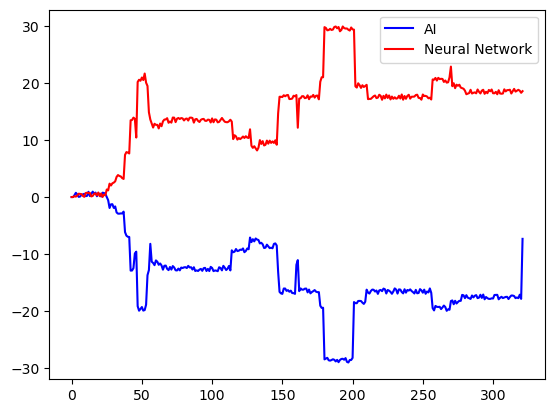

In [28]:
import numpy as np
import matplotlib.pyplot as pt


# visualize learning curves on train/test data
pt.plot(curve[0][0:j+1], 'b-')
pt.plot(curve[1][0:j+1], 'r-')
#pt.plot([0, len(curve[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
#for full board
pt.legend(["AI","Neural Network"])
pt.show()

In [34]:
#This method is for game that can be customized by the user

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
b1 = "8/8/7"+s+"/8/8/r7/1kr5/7K"
b2 = "8/8/8/8/B7/b6"+s+"/1kp5/7K"
b3 = "full board"
b4 = "8/1kr5/7"+s+"/8/8/r7/7K/8"
b5 = "8/7k/p1p2p2/7"+s+"/8/r7/1K1n4/8"
#b6= "8/8/8/8/8/8/7Q/5k1K"
print("select which problem instance board you want\n b1: ",b1,"\n b2:",b2,"\n b3: ",b3,"\n b4:",b4,"\n b5: ",b5)
b6 = input("Write b1 or b2 or b3 or b4 or b5")
if(b6=="b1"):
    board = chess.Board(b1)
elif(b6=="b2"):
    board = chess.Board(b2) 
elif(b6=="b3"):
    board = chess.Board()
elif(b6=="b4"):
    board = chess.Board(b4)
else:
    board = chess.Board(b5)
score=0

#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
#display_board(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
base1="Tree"
base2="Tree"
white = 1

if(choice==3):
    base1 = "Tree"

elif (choice==5):
    base2="NN"
    #white=0
elif(choice==4):
    base1="Tree"
    base2 = "Tree"
moves = 0
pgn = []
game = chess.pgn.Game()
evaluations = []
sm = 0
cnt = 0
curve  = [ [0]*2 for i in range(2)]
# curve = np.zeros((5,100,1000,2))

j=0
while((not board.is_game_over())):
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()
    if(white==1):
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    elif(choice==2 and white==0):
        print("input format should be something like a2, b6, g3, first one is row, second one is colum")
        print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
        to=input("Write where you want to go = ")
        frm = input("write from where you want to move = ")
        result=frm+to
    elif(choice==5 and white==0):
        start = time.time()
        #matrix = make_matrix(board.copy())
        translated = np.array(translate(matrix,chess_dict))
        #print(model.predict(translated.reshape(1,8,8,12)))
        #clear_output()
        #result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        result = calculate_move(3,board,5)
        #print("time taken for nn in iteration ",j,(time.time()-start))
    else:
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    try:
        board.push_san(result)

    except:
        print(result)
        print("invalid move. game over")
        break
    #print(result)
    score = staticAnalysis(board,white)
    col="BLACK"
    if(white):
        col="WHITE"
    print("score for ",col,"= ",score)

    curve[white].append(score)
    pgn.append(result)
    white ^= 1
    j+=1

    moves+=1
    #info = engine.analyse(board, chess.engine.Limit(depth=24))
    #evaluat += info['score'].white()
    print(board)

    print("-----------move done-----------")

print(" ".join(pgn))
print()
#{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

#print(info)
#print(evaluations)
#We are showing score for each player after each move, so in final result the score is only based on the winner.
#If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
print(board.result())

game.headers["Result"] = board.result()


We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?
p or P or Q or R or q or b . Only write the letter 
Q
select which problem instance board you want
 b1:  8/8/7Q/8/8/r7/1kr5/7K 
 b2: 8/8/8/8/B7/b6Q/1kp5/7K 
 b3:  full board 
 b4: 8/1kr5/7Q/8/8/r7/7K/8 
 b5:  8/7k/p1p2p2/7Q/8/r7/1K1n4/8
Write b1 or b2 or b3 or b4 or b5b5
. . . . . . . .
. . . . . . . k
p . p . . p . .
. . . . . . . Q
. . . . . . . .
r . . . . . . .
. K . n . . . .
. . . . . . . .
Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?
 write 1 or 2 or 3 or 4 or 5= 3
time taken to iteration 0 3.8731491565704346
score for  WHITE =  -0.6759064663430534
. . . . . . . .
. . . . . . . k
p . p . . p . .
. . . . . . . .
. . . . . . . .
r . . . . . . .
. K . n . . . .
. . . . . . . Q
-----------move done-----------
time taken to iteration 1 4.226

time taken to iteration 31 2.7374956607818604
score for  BLACK =  8.473676922824541
. . . . . k . .
. . . . . . . .
. . . . . p . .
p . p . . . . .
K . . . . . . .
. . . . . . . n
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 32 2.5096445083618164
score for  WHITE =  -7.481826456705712
. . . . . k . .
. . . . . . . .
. . . . . p . .
p . p . . . . .
. . . . . . . .
. K . . . . . n
. . . . . . . .
. . . . . . . .
-----------move done-----------
time taken to iteration 33 3.7151501178741455
score for  BLACK =  8.011169506027965
. . . . . k . .
. . . . . . . .
. . . . . p . .
p . p . . . . .
. . . . . . . .
. K . . . . . .
. . . . . . . .
. . . . . . n .
-----------move done-----------
time taken to iteration 34 2.4062764644622803
score for  WHITE =  -7.353461698136087
. . . . . k . .
. . . . . . . .
. . . . . p . .
p . p . . . . .
. . . . . . . .
K . . . . . . .
. . . . . . . .
. . . . . . n .
-----------move done-----------
time taken to iteratio

time taken to iteration 65 2.684718608856201
score for  BLACK =  6.078872154873178
. k . . . . . .
. . . . . . . .
. . . . . . . .
p . . . . . . .
. . . . . p . .
. . . . . . . .
. . . . . . . .
. K b . . . . .
-----------move done-----------
time taken to iteration 66 1.4728782176971436
score for  WHITE =  -1.9785226651391876
. k . . . . . .
. . . . . . . .
. . . . . . . .
p . . . . . . .
. . . . . p . .
. . . . . . . .
. . . . . . . .
. . K . . . . .
-----------move done-----------
time taken to iteration 67 1.602470874786377
score for  BLACK =  2.369830324011749
. . . . . . . .
k . . . . . . .
. . . . . . . .
p . . . . . . .
. . . . . p . .
. . . . . . . .
. . . . . . . .
. . K . . . . .
-----------move done-----------
time taken to iteration 68 2.4995574951171875
score for  WHITE =  -1.7236715769057267
. . . . . . . .
k . . . . . . .
. . . . . . . .
p . . . . . . .
. . . . . p . .
. . . . . . . .
. . . . . . . .
. K . . . . . .
-----------move done-----------
time taken to iteratio

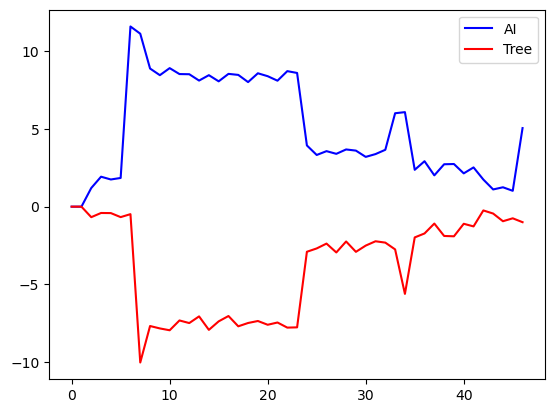

In [35]:
import numpy as np
import matplotlib.pyplot as pt


# visualize learning curves on train/test data
pt.plot(curve[0][0:j+1], 'b-')
pt.plot(curve[1][0:j+1], 'r-')
#pt.plot([0, len(curve[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
#for full board
pt.legend(["AI","Tree"])
pt.show()

In [ ]:
pip install tensorflow

In [ ]:
pip install keras

In [ ]:
pip install tensorflow


In [ ]:
pip uninstall eventlet

In [37]:
#This method is for game that can be customized by the user

#customizing problem size
#to randomize the starting position we can customize the board. for now I am using a random board setup
#board = chess.Board("r1bqkb1r/pppp1Qpp/2n2n2/4p3/2B1P3/8/PPPP1PPP/RNB1K1NR")
print("We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?")
s = input("p or P or Q or R or q or b . Only write the letter \n")
b1 = "8/8/7"+s+"/8/8/r7/1kr5/7K"
b2 = "8/8/8/8/B7/b6"+s+"/1kp5/7K"
b3 = "full board"
b4 = "8/1kr5/7"+s+"/8/8/r7/7K/8"
b5 = "8/7k/p1p2p2/7"+s+"/8/r7/1K1n4/8"
#b6= "8/8/8/8/8/8/7Q/5k1K"
print("select which problem instance board you want\n b1: ",b1,"\n b2:",b2,"\n b3: ",b3,"\n b4:",b4,"\n b5: ",b5)
b6 = input("Write b1 or b2 or b3 or b4 or b5")
if(b6=="b1"):
    board = chess.Board(b1)
elif(b6=="b2"):
    board = chess.Board(b2) 
elif(b6=="b3"):
    board = chess.Board()
elif(b6=="b4"):
    board = chess.Board(b4)
else:
    board = chess.Board(b5)
score=0

#to let the pc choose random positions
#board = chess.Board.from_chess960_pos(random.randint(0, 959))
#board = chess.Board()
print(board)
#display_board(board)
choice=int(input("Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?\n write 1 or 2 or 3 or 4 or 5= "))
base1="Tree"
base2="Tree"
white = 1

if(choice==3):
    base1 = "Tree"

elif (choice==5):
    base2="NN"
    #white=0
elif(choice==4):
    base1="Tree"
    base2 = "Tree"
moves = 0
pgn = []
game = chess.pgn.Game()
evaluations = []
sm = 0
cnt = 0
curve  = [ [0]*2 for i in range(2)]
# curve = np.zeros((5,100,1000,2))

j=0
while((not board.is_game_over())):
    all_moves = [board.san(i) for i in list(board.legal_moves)]
    start = time.time()
    if(white==1):
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    elif(choice==2 and white==0):
        print("input format should be something like a2, b6, g3, first one is row, second one is colum")
        print("row is a to h and colum is 1 to 8. if you are second player your pieces are small letter , otherwise capital")
        to=input("Write where you want to go = ")
        frm = input("write from where you want to move = ")
        result=frm+to
    elif(choice==5 and white==0):
        start = time.time()
        #matrix = make_matrix(board.copy())
        translated = np.array(translate(matrix,chess_dict))
        #print(model.predict(translated.reshape(1,8,8,12)))
        #clear_output()
        #result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        result = calculate_move(3,board,5)
        #print("time taken for nn in iteration ",j,(time.time()-start))
    else:
        root = node(board)
        root.state = board
        result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
        print("time taken to iteration",j,(time.time()-start))
    try:
        board.push_san(result)

    except:
        print(result)
        print("invalid move. game over")
        break
    #print(result)
    score = staticAnalysis(board,white)
    col="BLACK"
    if(white):
        col="WHITE"
    print("score for ",col,"= ",score)

    curve[white].append(score)
    pgn.append(result)
    white ^= 1
    j+=1

    moves+=1
    #info = engine.analyse(board, chess.engine.Limit(depth=24))
    #evaluat += info['score'].white()
    print(board)

    print("-----------move done-----------")

print(" ".join(pgn))
print()
#{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

#print(info)
#print(evaluations)
#We are showing score for each player after each move, so in final result the score is only based on the winner.
#If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
print(board.result())

game.headers["Result"] = board.result()


We want an input from you to arrange the board. We have randomized the pieces position with different numbers.Can you choose one from the following pieces you want in the board?
p or P or Q or R or q or b . Only write the letter 
Q
select which problem instance board you want
 b1:  8/8/7Q/8/8/r7/1kr5/7K 
 b2: 8/8/8/8/B7/b6Q/1kp5/7K 
 b3:  full board 
 b4: 8/1kr5/7Q/8/8/r7/7K/8 
 b5:  8/7k/p1p2p2/7Q/8/r7/1K1n4/8
Write b1 or b2 or b3 or b4 or b5b4
. . . . . . . .
. k r . . . . .
. . . . . . . Q
. . . . . . . .
. . . . . . . .
r . . . . . . .
. . . . . . . K
. . . . . . . .
Do you want 1. AI-AI game or 2.Human-AI game or 3.Baseline tree-AI tree game or 4. tree vs tree or 5.AI-NN game ?
 write 1 or 2 or 3 or 4 or 5= 2
time taken to iteration 0 2.980820655822754
score for  WHITE =  4.220896901749867
. . . . . Q . .
. k r . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
r . . . . . . .
. . . . . . . K
. . . . . . . .
-----------move done-----------
input format should be something l

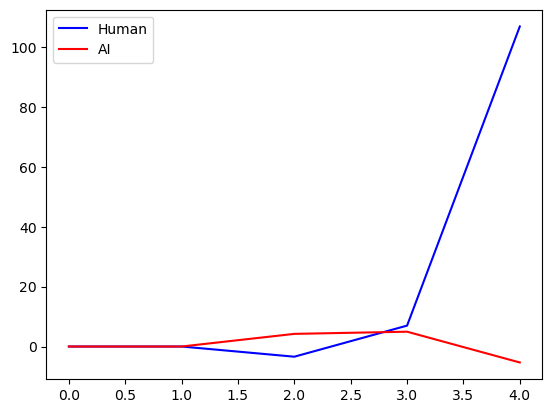

In [38]:
import numpy as np
import matplotlib.pyplot as pt


# visualize learning curves on train/test data
pt.plot(curve[0][0:j+1], 'b-')
pt.plot(curve[1][0:j+1], 'r-')
#pt.plot([0, len(curve[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
#for full board
pt.legend(["Human","AI"])
pt.show()